<a href="https://colab.research.google.com/github/barauna-lo/Entropys_MHD_vs_Hidro/blob/main/Entropys_MHD_vs_Hidro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.sciencedirect.com/science/article/pii/S2352340923000926

# Import Libraries

In [ ]:
!pip install git+https://github.com/rsautter/gpa/
!pip install git+https://github.com/barauna-lo/GPA.git
!pip install --force-reinstal git+https://github.com/rsautter/eta/
!pip install ordpy
!pip install colorednoise
!pip install healpy
!pip install pencil

  Cloning https://github.com/rsautter/gpa/ to /tmp/pip-req-build-1z5xncjz
  Running command git clone --filter=blob:none --quiet https://github.com/rsautter/gpa/ /tmp/pip-req-build-1z5xncjz
  Resolved https://github.com/rsautter/gpa/ to commit 2c011bb317699305375b9847baf7a6f4509c0b4c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for GPA: filename=gpa-3.5-cp311-cp311-linux_x86_64.whl size=1573485 sha256=363430aec8b87b11dc5067d71cc7e8f717a10b17dbf4a8cafb7404466281e9b6
  Stored in directory: /tmp/pip-ephem-wheel-cache-v8kn1hfx/wheels/fb/e9/39/b20b5e7a99635c0130edc486295db05c9dba45ba17c93d0fdf
Successfully built GPA
  Cloning https://github.com/barauna-lo/GPA.git to /tmp/pip-req-build-vvnt4006
  Running command git clone --filter=blob:none --quiet https://github.com/barauna-lo/GPA.git /tmp/pip-req-build-vvnt4006
  Resolved https://github.com/barauna-lo/GPA.git to commit 2c011bb317699305

# Libraries

In [ ]:
# import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap

from mpl_toolkits.axes_grid1 import inset_locator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset#, transFigure
from scipy.stats import linregress
import os
# import cv2
# import NCGL
import eta
import tqdm
from ordpy import *
from GPA import GPA
import glob
from PIL import Image

import colorednoise as cn
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import welch

import gdown
import time
import numpy as np


# Functions

In [ ]:
ga = GPA(0.0)
def df_entropys(data,nx=None,ny=None,GPA=False):
  df_data = []
  for i in tqdm.tqdm(range(len(data))):
    if GPA:
      s = data[i]
      d = eta.entropy(s,nx=nx,ny=ny)
      gpaRes = ga(s,moment=['G4'])
      d['G_4'] = np.real(np.absolute(gpaRes['G4']))
      df_data.append(d)

    else:
      # print(i)
      s = data[i]
      d = eta.entropy(s,nx=nx,ny=ny)
      df_data.append(d)
  return pd.DataFrame(df_data)


def df_GPAs(data):
    ga = GPA(0.0)
    df_data = []
    for i in tqdm.tqdm(range(len(data))):
        s = data[i]
        GPAs = ga(s,moment=['G1','G2','G3'])
        # GPAs['G4'] = np.real(np.absolute(ga(s,moment=['G4'])['G4']))
        df_data.append(GPAs)
    return pd.DataFrame(df_data)


def normalized(data):
  for i in range(len(data)):
    data[i] = data[i]/np.max(data[i])
  return data

# # Suposição: normalize() é uma função definida anteriormente no seu código
# def normalize(data, min_val, max_val):
#     return (data - min_val) / (max_val - min_val)

def normalize(arr, t_min=-1, t_max=1):
    norm_arr = []
    diff = t_max - t_min
    diff_arr = max(arr) - min(arr)
    for i in arr:
        temp = (((i - min(arr))*diff)/diff_arr) + t_min
        norm_arr.append(temp)
    return norm_arr



In [ ]:
def normalize_series(series):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    return scaler.fit_transform(series.reshape(-1, 1)).flatten()

def calculate_power_spectrum(series):
    f, Pxx = welch(series)
    return f, Pxx


In [ ]:
def normalize(data, min_value, max_value):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def triangle_kdeplot(dataset, colors=None,original_names=None,display_names=None,fontsize=None,class_names=None,
                     fill= True,alpha=1):
    if colors is None: colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
    if class_names is None:   class_names = ['Class ' + str(i) for i in range(len(dataset))]
    if original_names is None: original_names = dataset[0].columns.values.copy()
    if display_names is None: display_names = original_names.copy()
    for i in range(len(display_names)):
        if display_names[i] != "G_4": display_names[i] = display_names[i].replace('_', '\n').replace('Powerlaw', '')

    gs = GridSpec(len(display_names), len(display_names))
    for j in range(len(original_names)):
        for i in range(j, len(original_names)):
            plt.subplot(gs[i, j])
            if i == j:
                for k in range(len(dataset)):
                    ax = sns.kdeplot(dataset[k][original_names[i]], color=colors[k], common_norm=True)
                    for line in ax.lines:
                        line.set_ydata(normalize(line.get_ydata(), 0, 1))
                plt.xlabel(display_names[i] if display_names[i] != "G_4" else r"$G_4$", size=fontsize)
                plt.ylabel('Density', size=fontsize)
                plt.ylim(-0.01, 1.2)
            else:
                for k in range(len(dataset)):
                    if fill ==True:
                        sns.kdeplot(data=dataset[k], x=original_names[j], y=original_names[i], color=colors[k], fill=True,alpha=alpha)
                    else:
                        sns.kdeplot(data=dataset[k], x=original_names[j], y=original_names[i], color=colors[k], fill=False,alpha=alpha)
                    plt.xlabel(display_names[j] if display_names[j] != "G_4" else r"$G_4$", size=fontsize)
                    plt.ylabel(display_names[i] if display_names[i] != "G_4" else r"$G_4$", size=fontsize)
    handles = []
    for k in range(len(dataset)):
        handles.append(plt.Line2D([0], [0], color=colors[k], lw=2, label=class_names[k]))
    plt.legend(handles=handles, fontsize=None, loc='best', bbox_to_anchor=(1.05, 1))


In [ ]:
from sklearn import metrics
from scipy.stats import pearsonr
import numpy as np
import pandas as pd

def silhouette_score(dataset, names=None, print_results=False, prin_best_correlation=False, return_best_pair=False):
    if names is None:
        names = dataset[0].columns.values.copy()
    dim = len(names)
    max_score = -100
    best_correlation = ""
    scores = np.zeros((dim, dim))

    for j in range(len(names)):
        for i in range(j + 1, len(names)):
            ms = []
            for data in range(len(dataset)):
                m = dataset[data][[names[i], names[j]]].copy()  # Adicionando .copy() para evitar SettingWithCopyWarning
                m["class"] = data
                ms.append(m)

            m = pd.concat(ms, ignore_index=True)
            sc = metrics.silhouette_score(m[[names[i], names[j]]], m["class"], metric='euclidean')
            corr, p = pearsonr(m[names[i]], m[names[j]])
            corr = 1 - np.abs(corr)
            scores[i, j] = corr * sc
            scores[j, i] = corr * sc
            if corr * sc > max_score:
                max_score = corr * sc
                best_correlation = (names[i], names[j])
            if print_results:
                print(names[i], names[j], corr * sc)

    if prin_best_correlation:
        print(f"{best_correlation} with score {max_score}")

    if return_best_pair:
        return best_correlation
    else:
        return scores


In [ ]:
# def plot_silhouette_score(scores,cmap='hot',
#                      greek_letters = ['$S^h_H$', '$S^p_H$','$S^s_H$','$S^h_q$','$S^p_q$','$S^s_q$','$G_4$']):

#     fig, ax = plt.subplots()
#     cax= ax.imshow(scores, cmap=cmap)  # Plot the data

#     # Greek letters for labels
#     greek_letters = greek_letters[:scores.shape[0]]#

#     # Set the Greek letters as tick labels
#     ax.set_xticks(range(scores.shape[0]))
#     ax.set_yticks(range(scores.shape[0]))
#     ax.set_xticklabels(greek_letters,size=12)
#     ax.set_yticklabels(greek_letters,size=12)
#     # Move the x-axis tick labels to the top
#     ax.xaxis.set_ticks_position('top')

#     plt.colorbar(cax)


In [ ]:
import matplotlib.pyplot as plt

def plot_silhouette_score(scores, ax=None, cmap='hot', greek_letters=None):
    if greek_letters is None:
        greek_letters = ['$S^h_H$', '$S^p_H$', '$S^s_H$', '$S^h_q$', '$S^p_q$', '$S^s_q$', '$G_4$']

    if ax is None:
        fig, ax = plt.subplots()

    cax = ax.imshow(scores, cmap=cmap)  # Plot the data

    # Greek letters for labels
    greek_letters = greek_letters[:scores.shape[0]]#

    # Set the Greek letters as tick labels
    ax.set_xticks(range(scores.shape[0]))
    ax.set_yticks(range(scores.shape[0]))
    ax.set_xticklabels(greek_letters, size=12)
    ax.set_yticklabels(greek_letters, size=12)
    # Move the x-axis tick labels to the top
    ax.xaxis.set_ticks_position('top')

    plt.colorbar(cax, ax=ax)


In [ ]:
def name_to_greek_letter(name):
    names = ['Histogram_Shannon', 'Permutation_Shannon', 'Spectral_Shannon',
             'Histogram_PowerlawTsallis', 'Permutation_PowerlawTsallis',
             'Spectral_PowerlawTsallis', 'G_4']

    greek_letters = ['$S^h_H$', '$S^p_H$', '$S^s_H$', '$S^h_q$', '$S^p_q$', '$S^s_q$', '$G_4$']

    name_to_greek = dict(zip(names, greek_letters))

    return name_to_greek.get(name, "Name not found")


In [ ]:
def plot_one_pair(dataset, ax=None, colors=None, fontsize=15,fontsize_legend = 10 ,class_names=None, names_x=None, names_y=None,alpha_fill=0.3,aplha_scatter=1,ncols=2):
    if ax is None:
        ax = plt.gca()

    if colors is None:      colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
    if class_names is None: class_names = ['Class ' + str(i) for i in range(len(dataset))]
    if names_x is None: names_x = silhouette_score(dataset, return_best_pair=True)[0]
    if names_y is None: names_y = silhouette_score(dataset, return_best_pair=True)[1]

    for k in range(len(dataset)):
        sns.kdeplot(data=dataset[k], x=names_x, y=names_y, color=colors[k], fill=True, alpha=alpha_fill, label=class_names[k], ax=ax)
        ax.scatter(x=dataset[k][names_x], y=dataset[k][names_y], color=colors[k], s=5, edgecolors='k', linewidth=0.5,alpha=aplha_scatter)

    ax.set_xlabel(names_x.replace('_', ' ').replace('Powerlaw', '') + f" Entropy ({name_to_greek_letter(names_x)})", fontsize=fontsize)
    ax.set_ylabel(names_y.replace('_', ' ').replace('Powerlaw', '') + f" Entropy ({name_to_greek_letter(names_y)})", fontsize=fontsize)

    # Elementos da legenda
    legend_elements = [
        Patch(facecolor=color, edgecolor=color, label=label)
        for color, label in zip(colors, class_names)
    ]
    ax.legend(handles=legend_elements, fontsize=fontsize_legend, ncol=ncols)

In [ ]:

def convert_to_grayscale(images, is_normal=False):
    images_gray = []
    for class_images in images:
        class_images_gray = []
        for image in class_images:
            if image.shape[-1] == 3:  # Check if the image has 3 channels (RGB)
                # Convert image to uint8 if it's not already
                if image.dtype != np.uint8:
                    image = (255 * image).astype(np.uint8)
                grayscale_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
                if is_normal:
                    grayscale_image = grayscale_image / 255.0  # Normalize to [0, 1]
                class_images_gray.append(grayscale_image)
            else:
                print(f"Skipping image with shape {image.shape}, expected RGB image.")
        images_gray.append(np.array(class_images_gray))
    return images_gray

In [ ]:
def read_n_images_from_fits(folder_path, n_images, is_normal=True):
    fits_files = [f for f in os.listdir(folder_path) if f.endswith('.fit') or f.endswith('.fits')]

    images = []
    count = 0

    for fits_file in fits_files:
        if count >= n_images:
            break

        file_path = os.path.join(folder_path, fits_file)

        with fits.open(file_path) as hdul:
            data = hdul[0].data
            if is_normal:
                data = (data - np.min(data)) / (np.max(data) - np.min(data))
            images.append(data)
            count += 1

    return images

def crop_centered_images(images, radius, nx, ny):
    cropped_images = []

    for img in images:
        if radius is not None:
            center_y, center_x = img.shape[0] // 2, img.shape[1] // 2
            start_y = max(center_y - radius - ny, 0)
            end_y = min(center_y + radius + ny, img.shape[0])
            start_x = max(center_x - radius - nx, 0)
            end_x = min(center_x + radius + nx, img.shape[1])

            cropped_img = img[start_y:end_y, start_x:end_x]
        else:
            cropped_img = img

        # Segmentar apenas a galáxia, garantindo que apenas valores significativos sejam considerados
        threshold = 0.05  # Ajuste o valor do limiar conforme necessário
        segmented_img = np.where(cropped_img > threshold, cropped_img, 0)

        # Adicionar ao output apenas se tiver valores diferentes de zero
        if np.any(segmented_img):
            cropped_images.append(segmented_img)

    return cropped_images


In [ ]:
# Neutrinos

def plot_psd(data,label='PSD',color='k',linewidth=1,is_subplot = False,axis=None):
  '''
  This functions will show the PSD representation for any time series
  '''
  ft   = np.fft.fft(data)
  ft   = np.real(ft*np.conj(ft))
  freq = np.fft.fftfreq(len(ft))
  cond = (freq>0.0)
  ft,freq = ft[cond],freq[cond]
  seq  = np.argsort(freq)

  a,b  = np.polyfit(np.log(freq[freq>0.0]),np.log(ft[freq>0.0]),deg=1)
  text = "{} {}f + {}".format(label,np.round(a,3),np.round(b,3))
  #plota o psd
  if is_subplot:
    return freq[seq],ft[seq], a,b
  else:
    return plt.loglog(freq[seq],ft[seq],color=color,label=text,linewidth=linewidth)


#for i in range(len(signal_and_noise)):
def plot_images(signal_and_noise,signal,noise,i=0,v_max=None,v_min=None):
        # plt.figure(figsize=(7, 9))
        plt.suptitle(f"Image Representation of All Channels for Event {i+1}", fontsize=16)

        if not v_max:
            v_max = np.max(noise)
        if not v_min:
            v_min = np.min(noise)


        plt.subplot(3, 1, 1)
        plt.imshow(signal[i], aspect='auto',
                   interpolation='nearest',
                   vmin=v_min,#np.min(a),
                   vmax=v_max)#np.max(a))
        plt.colorbar()
        plt.title("Signal")
        plt.ylabel('Channels')

        plt.subplot(3, 1, 2)
        plt.imshow(noise[i],
                aspect='auto',
                interpolation='nearest',
                vmin=v_max,
                vmax=v_max)
        plt.colorbar()
        plt.title("Noise")
        plt.ylabel('Channels')
        plt.tight_layout()

        plt.subplot(3, 1, 3)
        plt.imshow(signal_and_noise[i], aspect='auto', interpolation='nearest',
                   vmin=v_max,
                   vmax=v_max)
        plt.colorbar()
        plt.ylabel('Channels')
        plt.title("Signal + Noise")

        return plt.show()



def plot_signals(signal_and_noise,signal,noise,i=0,k=0,ylim=None):

    if ylim is None:
        ylim = (np.min(signal_and_noise[i][k]),np.max(signal_and_noise[i][k]))
    else:
        ylim = ylim

    # plt.figure(figsize=(15,6))
    #plt.imshow(signal_and_noise[i],aspect='auto')
    #Set the imagem background to white
    plt.rcParams['figure.facecolor'] = 'white'
    plt.suptitle(f'Event {i+1} ; Channel {k+1}')
    plt.subplot(3,5,(1,4))
    plt.title('Original Data')
    plt.ylim = ylim
    plt.plot(signal_and_noise[i][k])

    plt.subplot(3,5,5)
    plt.ylabel('PSD')
    plt.xlabel('Frequency')
    plot_psd(signal_and_noise[i][k],label='Original Data',color='C1',linewidth=1)
    plt.legend(bbox_to_anchor=(0.5, 1), loc='lower center', ncol=2)

    #noise_less = np.load('noiseless/noiseless_00.npy')
    plt.subplot(3,5,(6,9))
    plt.title('Signal')
    plt.plot(signal[i][k])
    plt.ylim = ylim

    plt.subplot(3,5,10)
    plt.ylabel('PSD')
    plt.xlabel('Frequency')
    plot_psd(signal[i][k],label='Signal',color='C1',linewidth=1)
    plt.legend(bbox_to_anchor=(0.5, 1), loc='lower center', ncol=2)

    plt.subplot(3,5,(11,14))
    plt.title('Noise')
    plt.plot(noise[i][k])
    plt.ylim = ylim

    plt.subplot(3,5,15)
    plt.ylabel('PSD')
    plt.xlabel('Frequency')
    plot_psd(noise[i][k],label='Noise',color='C1',linewidth=1)
    plt.legend(bbox_to_anchor=(0.5, 1), loc='lower center', ncol=2)

    plt.tight_layout()

    return plt.show()

def plot_3d_signals(signal_and_noise,signal,noise,i=0,k=0):
    datas = [signal_and_noise[i], signal[i], noise[i]]
    titles = ['Original Data', 'Signal', 'Noise']
    # Set up the figure
    fig.suptitle(f'Radio Data for event {i+1}',y=0.95, fontsize=20)
    for l in range(3):
        data = datas[l]
        ax = fig.add_subplot(1,3,l+1, projection='3d')
        # Loop over each channel and plot it in the same 3D chart
        for k in range(11):
            xs = range(2048)
            ys = [k] * 2048
            zs = data[k]
            ax.plot(xs, ys, zs, label='Channel {}'.format(k+1))
        # Set the axis labels and legend
        ax.set_xlabel('Time')
        ax.set_ylabel('Channel')
        ax.set_zlabel('Amplitude')
        ax.set_title(titles[l])
    ax.legend(bbox_to_anchor=(1.1, .5), loc='upper left', borderaxespad=0.)
    return plt.show()

def plot_3d_plotly(data,i=0):
    data = data[i]
    event = i
    traces = []
    for i in range(11):
        trace = go.Scatter3d(
            x=np.arange(2048),
            y=np.ones(2048) * i,
            z=data[i],
            name=f'Channel {i+1}',
            mode='lines',
            line=dict(width=2),
        )
        traces.append(trace)

    # Create the layout
    layout = go.Layout(
        title=f'Radio Data for event {event+1}',
        scene=dict(
            xaxis=dict(title='Time'),
            yaxis=dict(title='Channel'),
            zaxis=dict(title='Amplitude'),
        ),
    )

    # Create the figure and plot it
    fig = go.Figure(data=traces, layout=layout)
    return fig.show()


In [ ]:
import numpy as np
import healpy as hp
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt

def get_normalized_rotated_map(fits_path, res=800, rot=[0, 0, 0], vmin_percentile=2, vmax_percentile=98,with_header=True):
    """
    Retorna um array 2D com os dados normalizados e rotacionados a partir de um arquivo .fits.

    Parâmetros:
    fits_path (str): Caminho para o arquivo .fits.
    res (int): Resolução da projeção. Padrão é 800.
    rot (list): Rotação para o mapa [lon, lat, psi]. Padrão é [0, 0, 0].
    vmin_percentile (float): Percentil mínimo para normalização. Padrão é 2.
    vmax_percentile (float): Percentil máximo para normalização. Padrão é 98.

    Retorna:
    np.ndarray: Array 2D com os dados normalizados e rotacionados.
    """
    # Ler o arquivo .fits
    if with_header:
        mapa, header = hp.read_map(fits_path, h=True, field=[0, 1, 2], verbose=False)
    else: mapa = hp.read_map(fits_path)

    # Definir a resolução da projeção
    nside = hp.get_nside(mapa[0] if with_header else mapa)
    npix = hp.nside2npix(nside)

    # Converter o mapa para coordenadas 2D
    lon = np.linspace(-180, 180, res)
    lat = np.linspace(-90, 90, res)
    lon, lat = np.meshgrid(lon, lat)

    # Converter coordenadas esféricas para coordenadas cartesianas
    theta = np.radians(90 - lat).flatten()
    phi = np.radians(lon).flatten()

    # Aplicar a rotação
    r = hp.Rotator(rot=rot)
    theta_rot, phi_rot = r(theta, phi)
    pix_rot = hp.ang2pix(nside, theta_rot, phi_rot)

    # Criar o mapa 2D rotacionado
    mapa_2d_rot = mapa[0][pix_rot].reshape((res, res)) if with_header else mapa[pix_rot].reshape((res, res))

    # Normalização baseada no histograma
    vmin = np.percentile(mapa_2d_rot, vmin_percentile)
    vmax = np.percentile(mapa_2d_rot, vmax_percentile)
    mapa_2d_rot_norm = np.clip((mapa_2d_rot - vmin) / (vmax - vmin), 0, 1)

    return mapa_2d_rot_norm


In [ ]:
import pandas as pd
import numpy as np

def gerar_tabela_latex(dataframes, nomes,is_greek=True, round_media=4, round_std=4):
    # Verificar se o comprimento dos arrays de dataframes e nomes é o mesmo
    if len(dataframes) != len(nomes):
        raise ValueError("O número de dataframes e nomes deve ser o mesmo.")

    # Inicializar uma string para armazenar a tabela LaTeX
    tabela_latex = "\\begin{table}[!ht]\\label{tab:dataset}\n\\caption{}\n"
    tabela_latex += "  \\begin{center}\n    \\begin{tabular}{l" + " c" * len(dataframes) + "}\n"
    tabela_latex += "      \\hline\n"

    # Adicionar o cabeçalho da tabela
    tabela_latex += "\\textbf{d}"
    for nome in nomes:
        tabela_latex += f" & \\textbf{{{nome}}} "
    tabela_latex += "\\\\ \\midrule\n"

    # Adicionar as linhas da tabela
    colunas = dataframes[0].columns
    for coluna in colunas:
        if is_greek:
            coluna_formatada = name_to_greek_letter(coluna)
        else:
            coluna_formatada = coluna.replace("_", " ").replace("Powerlaw", "")

        linha = coluna_formatada
        for df in dataframes:
            media = df[coluna].mean()
            desvio_padrao = df[coluna].std()
            linha += f" & {round(media,round_media)} ± {round(desvio_padrao,round_std)}"
        tabela_latex += linha + "\\\\\n"

    # Fechar a tabela LaTeX
    tabela_latex += "      \\hline\n    \\end{tabular}\n  \\end{center}\n\\end{table}"

    return tabela_latex


In [ ]:
import pandas as pd
import numpy as np

def gerar_tabela_latex2(dataframes, nomes=None, is_greek=True,round_media=4, round_std=4, long_table=False):
    # Verificar se o comprimento dos arrays de dataframes e nomes é o mesmo
    if nomes==None:
        nomes = [f"Class {i+1}" for i in range(len(dataframes))]

    if len(dataframes) != len(nomes):
        raise ValueError("O número de dataframes e nomes deve ser o mesmo.")

    if long_table:
        # Inicializar uma string para armazenar a tabela LaTeX em formato longo
        tabela_latex = "\\setlongtables\n\\begin{landscape}\n\\begin{longtable}[c]{l" + " c" * len(dataframes) + "}\n"
        tabela_latex += "\\caption{Média e desvio padrão das colunas dos dataframes.}\\label{tab:longa}\\\\\n"
        tabela_latex += "\\hline\n"

        # Adicionar o cabeçalho da tabela
        tabela_latex += "\\textbf{Coluna}"
        for nome in nomes:
            tabela_latex += f" & \\textbf{{{nome}}} "
        tabela_latex += "\\\\ \\hline\\hline\n\\endfirsthead\n"
        tabela_latex += "\\caption[]{Conclusão}\\\\\n\\hline\n"
        tabela_latex += "\\textbf{Coluna}"
        for nome in nomes:
            tabela_latex += f" & \\textbf{{{nome}}} "
        tabela_latex += "\\\\ \\hline\\hline\n\\endhead\n\\endlastfoot\n\\hline\n\\multicolumn{" + str(len(dataframes) + 1) + "}{r}{\\captionlabelfont\\captionsize(Continua)}\\\\\n\\endfoot\n"
    else:
        # Inicializar uma string para armazenar a tabela LaTeX em formato normal
        tabela_latex = "\\begin{table}[!ht]\\label{tab:dataset}\n\\caption{Média e desvio padrão das colunas dos dataframes.}\n"
        tabela_latex += "  \\begin{center}\n    \\begin{tabular}{l" + " c" * len(dataframes) + "}\n"
        tabela_latex += "      \\hline\n"

        # Adicionar o cabeçalho da tabela
        tabela_latex += "\\textbf{Coluna}"
        for nome in nomes:
            tabela_latex += f" & \\textbf{{{nome}}} "
        tabela_latex += "\\\\ \\midrule\n"

    # Adicionar as linhas da tabela
    colunas = dataframes[0].columns
    for coluna in colunas:
        if is_greek:
            coluna_formatada = name_to_greek_letter(coluna)
        else:
            coluna_formatada = coluna.replace("_", " ").replace("Powerlaw", "")

        # coluna_formatada = coluna.replace("_", " ").replace("Powerlaw", "")
        linha = coluna_formatada
        for df in dataframes:
            media = df[coluna].mean()
            desvio_padrao = df[coluna].std()
            # linha += f" & {media:.{round_media}f} ± {desvio_padrao:.{round_std}f} "
            linha += f" & {round(media,round_media)} ± {round(desvio_padrao,round_std)}"
        tabela_latex += linha + "\\\\\n"

    # Fechar a tabela LaTeX
    if long_table:
        tabela_latex += "\\hline\n\\end{longtable}\n\\vspace{-8mm}\n\\begin{center}\n  Fonte: Referência a fonte da tabela.\n\\end{center}\n\\end{landscape}"
    else:
        tabela_latex += "      \\hline\n    \\end{tabular}\n  \\end{center}\n\\end{table}"

    return tabela_latex

# # Exemplo de uso
# dataframes = [pd.DataFrame(np.random.randn(100, 3), columns=["Coluna1_Powerlaw", "Coluna2_Powerlaw", "Coluna3_Powerlaw"]),
#               pd.DataFrame(np.random.randn(100, 3), columns=["Coluna1_Powerlaw", "Coluna2_Powerlaw", "Coluna3_Powerlaw"])]
# nomes = ["DataFrame 1", "DataFrame 2"]

# # Definindo a precisão para a média e o desvio padrão
# round_media = 3
# round_std = 3

# # Gerando a tabela normal
# tabela_latex_normal = gerar_tabela_latex(dataframes, nomes, round_media, round_std, long_table=False)
# print(tabela_latex_normal)

# # Gerando a tabela longa
# tabela_latex_longa = gerar_tabela_latex(dataframes, nomes, round_media, round_std, long_table=True)
# print(tabela_latex_longa)


In [ ]:
def plot_3D(data_cube,selected_slice=None,ax=None,title = "",alpha_scater = 0.2,scater_color = 'blue',scater_size = 0.3,alpha_surface = 0.5,alpha_surface_others = 0.1,color_map  = 'viridis'):
    # selected_slice =data_cube.shape[0]//2 #j
  if ax == None:
    fig = plt.figure(figsize=(10, 10),dpi=50)
        # Plot 3D noise cube in the first row
    ax = fig.add_subplot(1,1 , 1, projection='3d')

  x, y, z  = np.indices(data_cube.shape)
  mask = data_cube > data_cube.mean() + 0.2 * data_cube.std()
  ax.scatter(x[mask], y[mask], z[mask], alpha=alpha_scater, color=scater_color,s=scater_size)

  if selected_slice != None:
    # Extract the selected slice for 3D plotting
    central_slice = data_cube[selected_slice,:, :]
    Y, Z = np.meshgrid(range(data_cube.shape[1]), range(data_cube.shape[2]))
    X = np.full(Y.shape, selected_slice)

    color_map = getattr(plt.cm, color_map)
    colors = color_map((central_slice - central_slice.min()) / (central_slice.max() - central_slice.min()))
    ax.plot_surface(X, Y, Z, facecolors=colors, rstride=1, cstride=1, shade=False,alpha=alpha_surface)

  ax.set_title(title,size=30)
  ax.axis('off')

# 1D Colored Noise

## Data

### Generate Data

In [ ]:
# # Parameters
# n_samples = 2048
# n_series = 1000
# betas = [0, 1, 5/3, 2]

# # Initialize the array to store time series data
# time_series = np.zeros((len(betas), n_series, n_samples))

# # Generate and normalize time series for each beta
# for i, beta in enumerate(betas):
#     for j in range(n_series):
#         series = cn.powerlaw_psd_gaussian(beta, n_samples)
#         time_series[i, j, :] = normalize_series(series)


In [ ]:
# def normalized(data):
#   for i in range(len(data)):
#     data[i] = data[i]/np.max(data[i])
#   return data

# for i in range(len(time_series)):
#     time_series[i] = normalized(time_series[i])
# # #save time_series
# # path = "/home/barauna/MEGA/Academia/DOUTORADO/Tese/data/"
# # np.save(f'{path}time_series.npy', time_series)

### Load data

In [ ]:
#Load time_series
path = "/home/barauna/MEGA/Academia/DOUTORADO/Tese/data/"

betas = [0, 1, 5/3, 2]
time_series = np.load(f'{path}time_series.npy')

# # Load Entropies
dfbetas0 = pd.read_csv(f'{path}dfbetas0.csv')
dfbetas1 = pd.read_csv(f'{path}dfbetas1.csv')
dfbetas53 = pd.read_csv(f'{path}dfbetas53.csv')
dfbetas2 = pd.read_csv(f'{path}dfbetas2.csv')

dataset_colored = [dfbetas0, dfbetas1, dfbetas53, dfbetas2]

## Vizualize data

NameError: name 'calculate_power_spectrum' is not defined

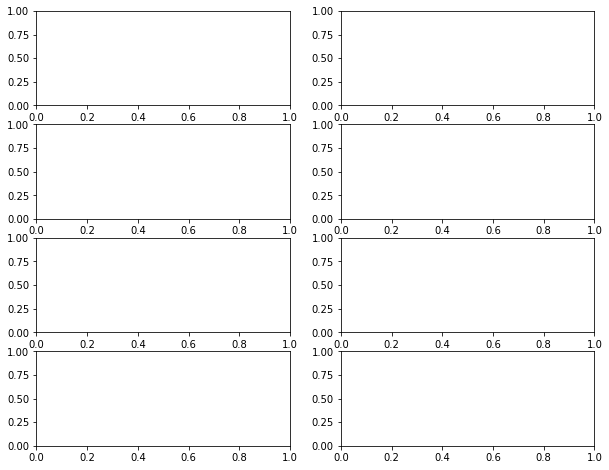

In [ ]:

# Create subplots
fig, axes = plt.subplots(len(betas), 2, figsize=(10, 8))
colors_colores_noise = ['black', 'magenta', 'blue', 'red']

for i, beta in enumerate(betas):
    # Select an example time series
    series_example = time_series[i, 0]

    # Calculate the power spectrum
    f, Pxx = calculate_power_spectrum(series_example)

    # Perform linear regression on the log-log plot
    slope, intercept, r_value, p_value, std_err = linregress(np.log(f[1:]), np.log(Pxx[1:]))

    # Plot time series
    axes[i, 0].plot(series_example, color=colors_colores_noise[i], linewidth=0.5)
    if i == 0:
        axes[i, 0].set_title(f'Time Series\n$\\beta={beta}$')
    else:
        axes[i, 0].set_title(f'$\\beta={beta}$')

    # Plot power spectrum
    axes[i, 1].plot(f, Pxx, color=colors_colores_noise[i], linewidth=0.5)
    axes[i, 1].set_xscale('log')
    axes[i, 1].set_yscale('log')
    if i == 0:
        axes[i, 1].set_title(f'Power Spectrum\n$\\beta={beta}$')
    else:
        axes[i, 1].set_title(f'$\\beta={beta}$')

    axes[i, 1].legend([f'$\\beta$ = {slope:.3f}'], loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()


## Preprocessing

In [ ]:
# dfbetas0 =  df_entropys(time_series[0])
# dfbetas1 =  df_entropys(time_series[1])
# dfbetas53 =  df_entropys(time_series[2])
# dfbetas2 =  df_entropys(time_series[3])

In [ ]:
# # # Save Entropies
# path = "/home/barauna/MEGA/Academia/DOUTORADO/Tese/data/"
# dfbetas0.to_csv(  f'{path}dfbetas0.csv', index=False)
# dfbetas1.to_csv(  f'{path}dfbetas1.csv', index=False)
# dfbetas53.to_csv(  f'{path}dfbetas53.csv', index=False)
# dfbetas2.to_csv(  f'{path}dfbetas2.csv', index=False)

In [ ]:
# # Load Entropies
path = "/home/barauna/MEGA/Academia/DOUTORADO/Tese/data/"
dfbetas0 = pd.read_csv(f'{path}dfbetas0.csv')
dfbetas1 = pd.read_csv(f'{path}dfbetas1.csv')
dfbetas53 = pd.read_csv(f'{path}dfbetas53.csv')
dfbetas2 = pd.read_csv(f'{path}dfbetas2.csv')

dataset_colored = [dfbetas0, dfbetas1, dfbetas53, dfbetas2]


## Results

In [ ]:

colors_colores_noise = ['black', 'magenta', 'blue', 'red']
class_names_colores_noise = ['$\\beta = 0$', '$\\beta = 1$', '$\\beta = 5/3$', '$\\beta = 2$']


('Histogram_PowerlawTsallis', 'Permutation_Shannon') with score 0.10273197611153756


<Figure size 1500x1200 with 0 Axes>

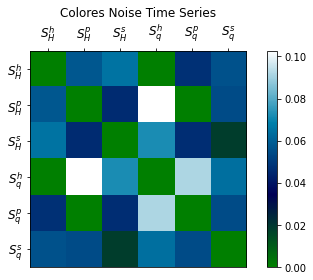

In [ ]:
scores_colored_noise = silhouette_score(dataset_colored,prin_best_correlation=True)

plt.figure(figsize=(5,4),dpi=300)
plot_silhouette_score(scores_colored_noise,cmap='ocean')
plt.title("Colores Noise Time Series")
plt.tight_layout()
save_path = "/home/barauna/MEGA/Academia/DOUTORADO/Tese/figuras/"
# plt.savefig(f'{save_path}Silhueta_colored_noise.pdf',dpi=300)
# plt.savefig(f'{save_path}Silhueta_colored_noise.png',dpi=100)
plt.show()

<ipython-input-304-4b7852156087>:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


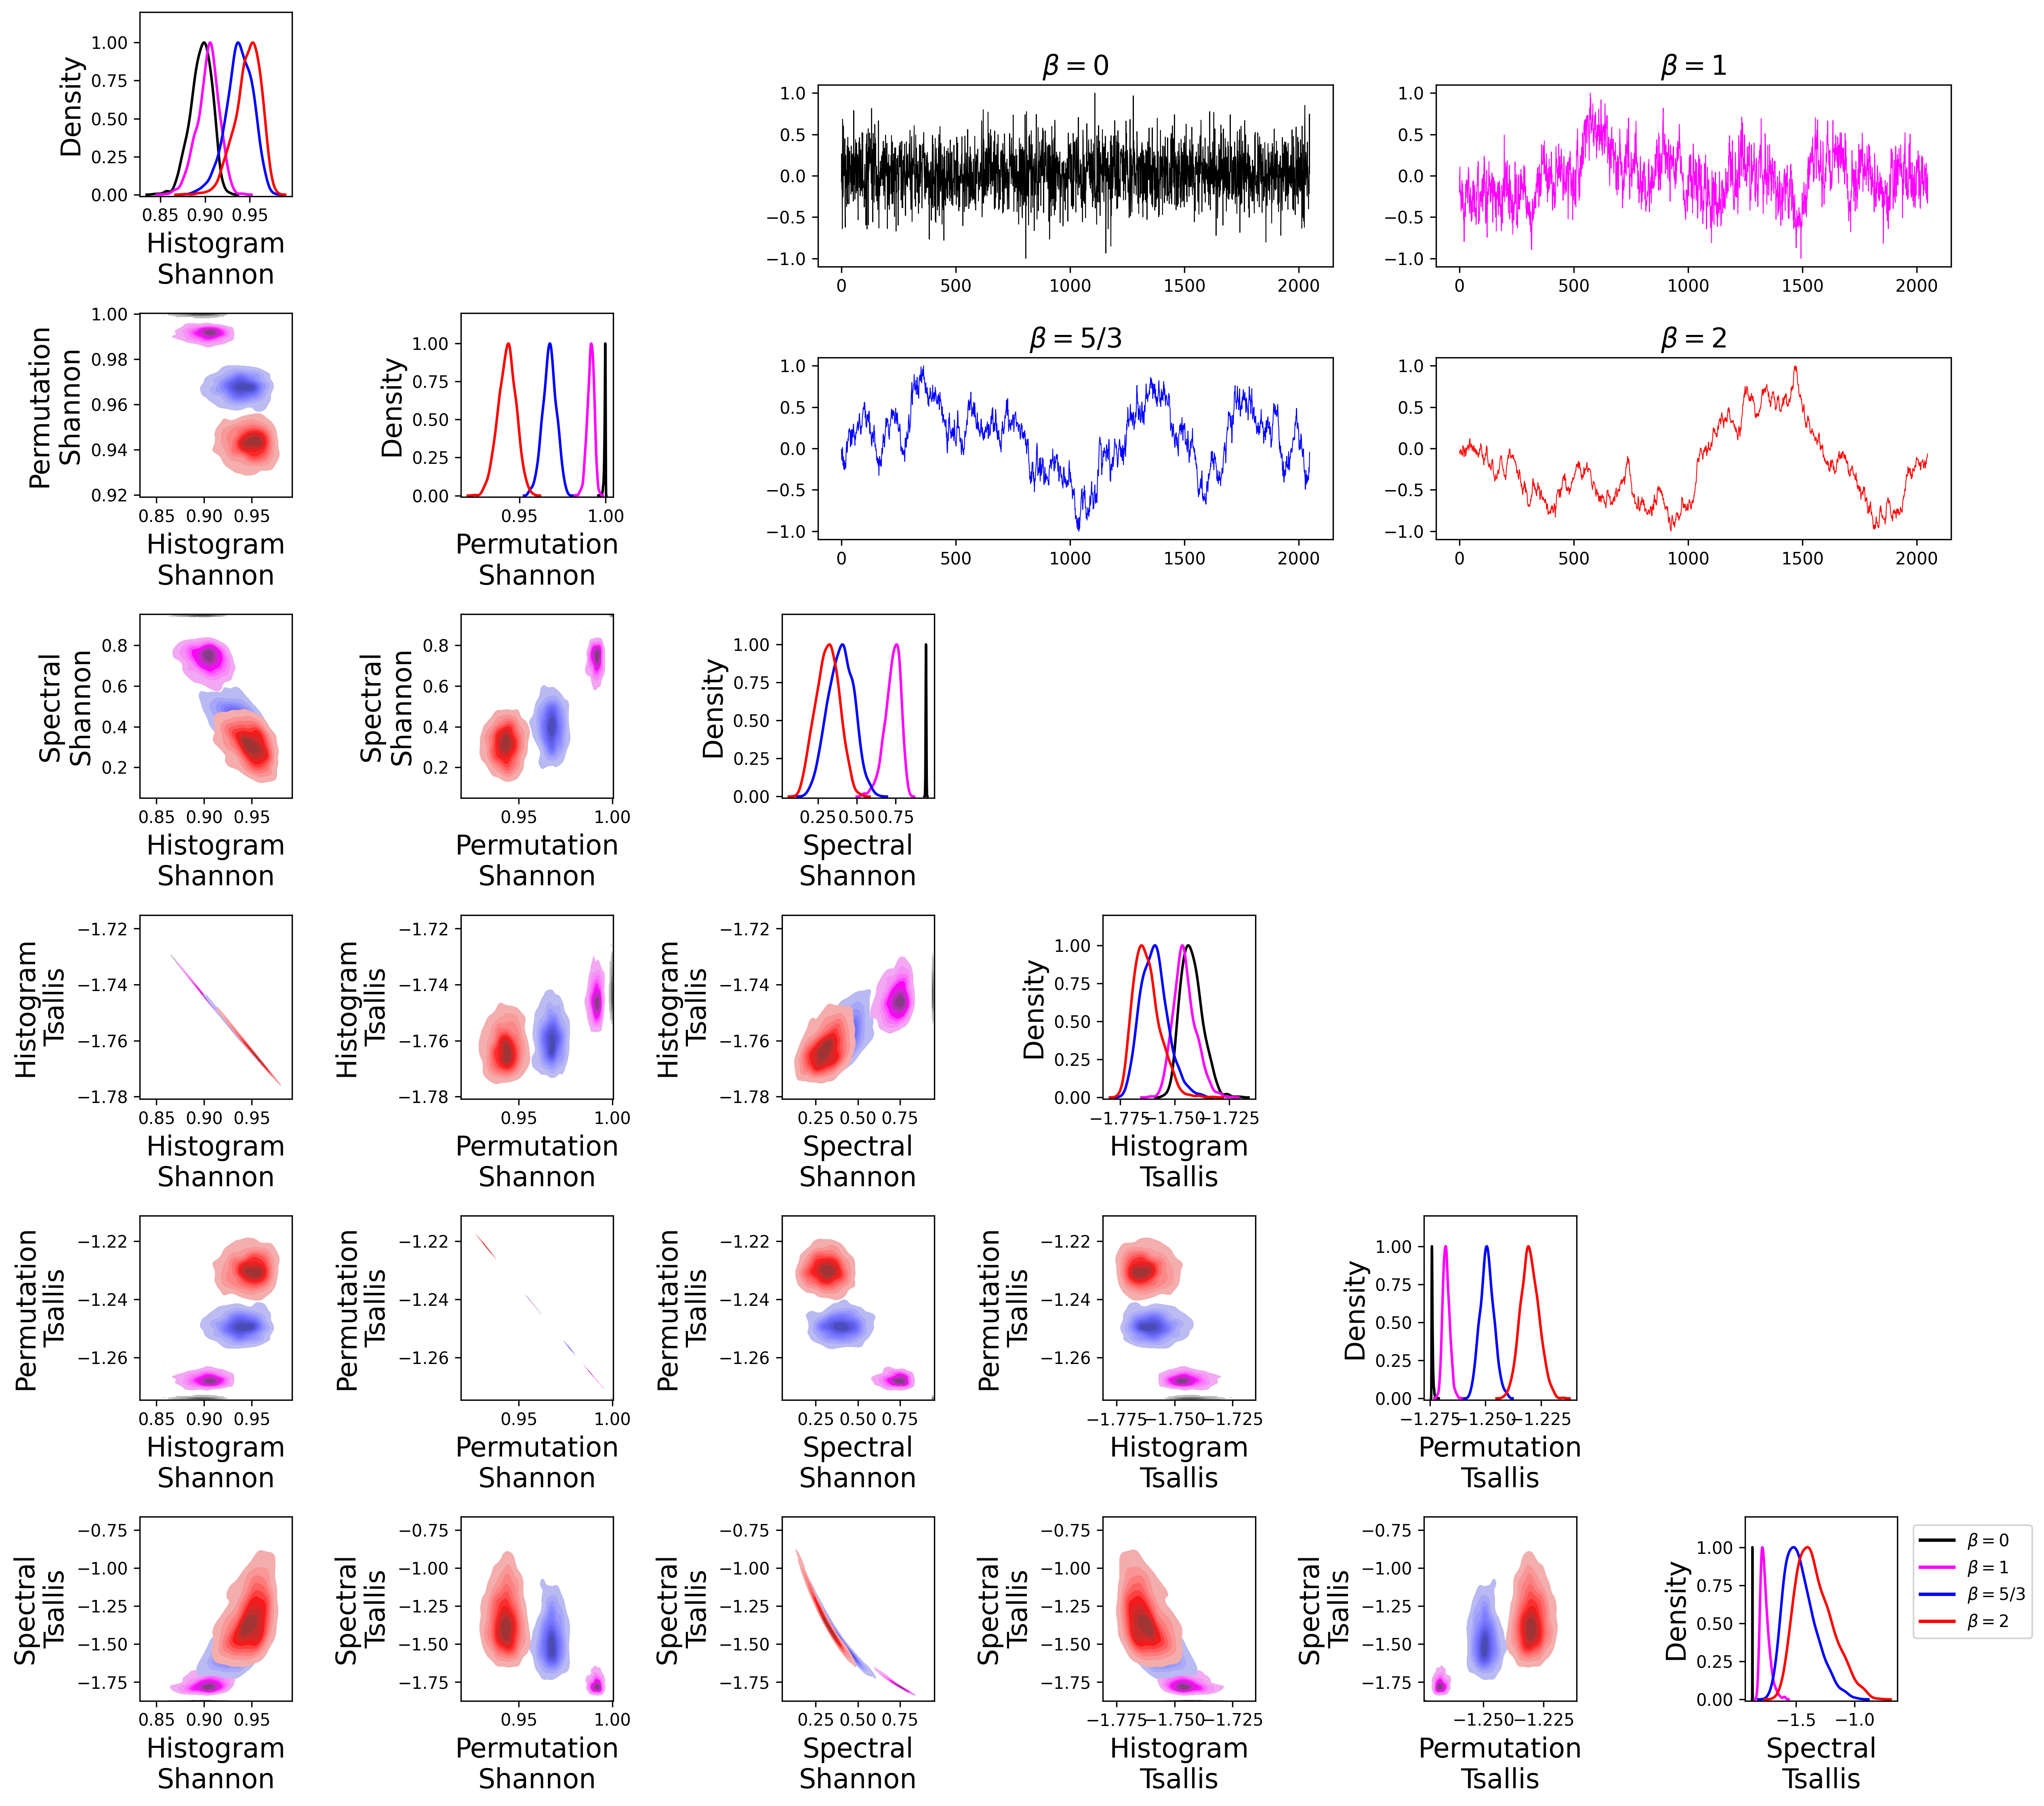

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import pandas as pd

fontsize = 16

# colors_colores_noise
# class_names_colores_noise

fig = plt.figure(figsize=(17, 15), dpi=300)

triangle_kdeplot(dataset_colored, colors=colors_colores_noise,fontsize=fontsize,class_names= class_names_colores_noise)#,fontsize=fontsize)

# # Inserir imagens na parte inferior da figura
# img_positions_serie = [(0.4, .85), (0.7, .85), (0.4, .7),  (0.70, .7)]

# Width, Height = 0.25, 0.1
# for k in range(4):
#     ax_img = fig.add_axes([img_positions_serie[k][0], img_positions_serie[k][1], Width, Height],zorder=1000)
#     ax_img.plot(time_series[k, 0], color=colors_colores_noise[k], linewidth=0.5)
#     ax_img.set_title(class_names_colores_noise[k], fontsize=fontsize)
#     # ax_img.axis('off')

# plt.tight_layout()
# save_imagens_path = "/home/barauna/MEGA/Academia/DOUTORADO/Tese/figuras/"
# plt.savefig(f'{save_imagens_path}triangle_KDE_colored.png', dpi=100)
# plt.savefig(f'{save_imagens_path}triangle_KDE_colored.pdf', dpi=300)
# plt.show()

In [ ]:
names_x = silhouette_score(dataset_colored,return_best_pair=True)[0]
names_y = silhouette_score(dataset_colored,return_best_pair=True)[1]

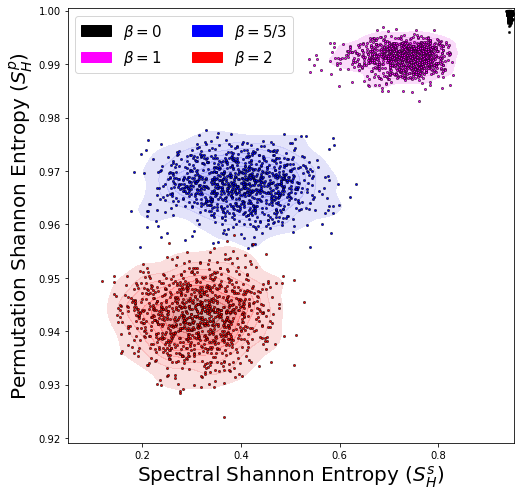

In [ ]:
fontsize = 20

plt.figure(figsize=(8, 8))

fontsize = 20

plot_one_pair(dataset_colored,
              colors = colors_colores_noise,
               names_x = names_x,
                names_y = names_y,
              class_names = class_names_colores_noise,fontsize=fontsize)

# plt.savefig(f'{save_imagens_path}pairplot_colored_noise.pdf', dpi=300)
# plt.savefig(f'{save_imagens_path}pairplot_colored_noise.png', dpi=100)


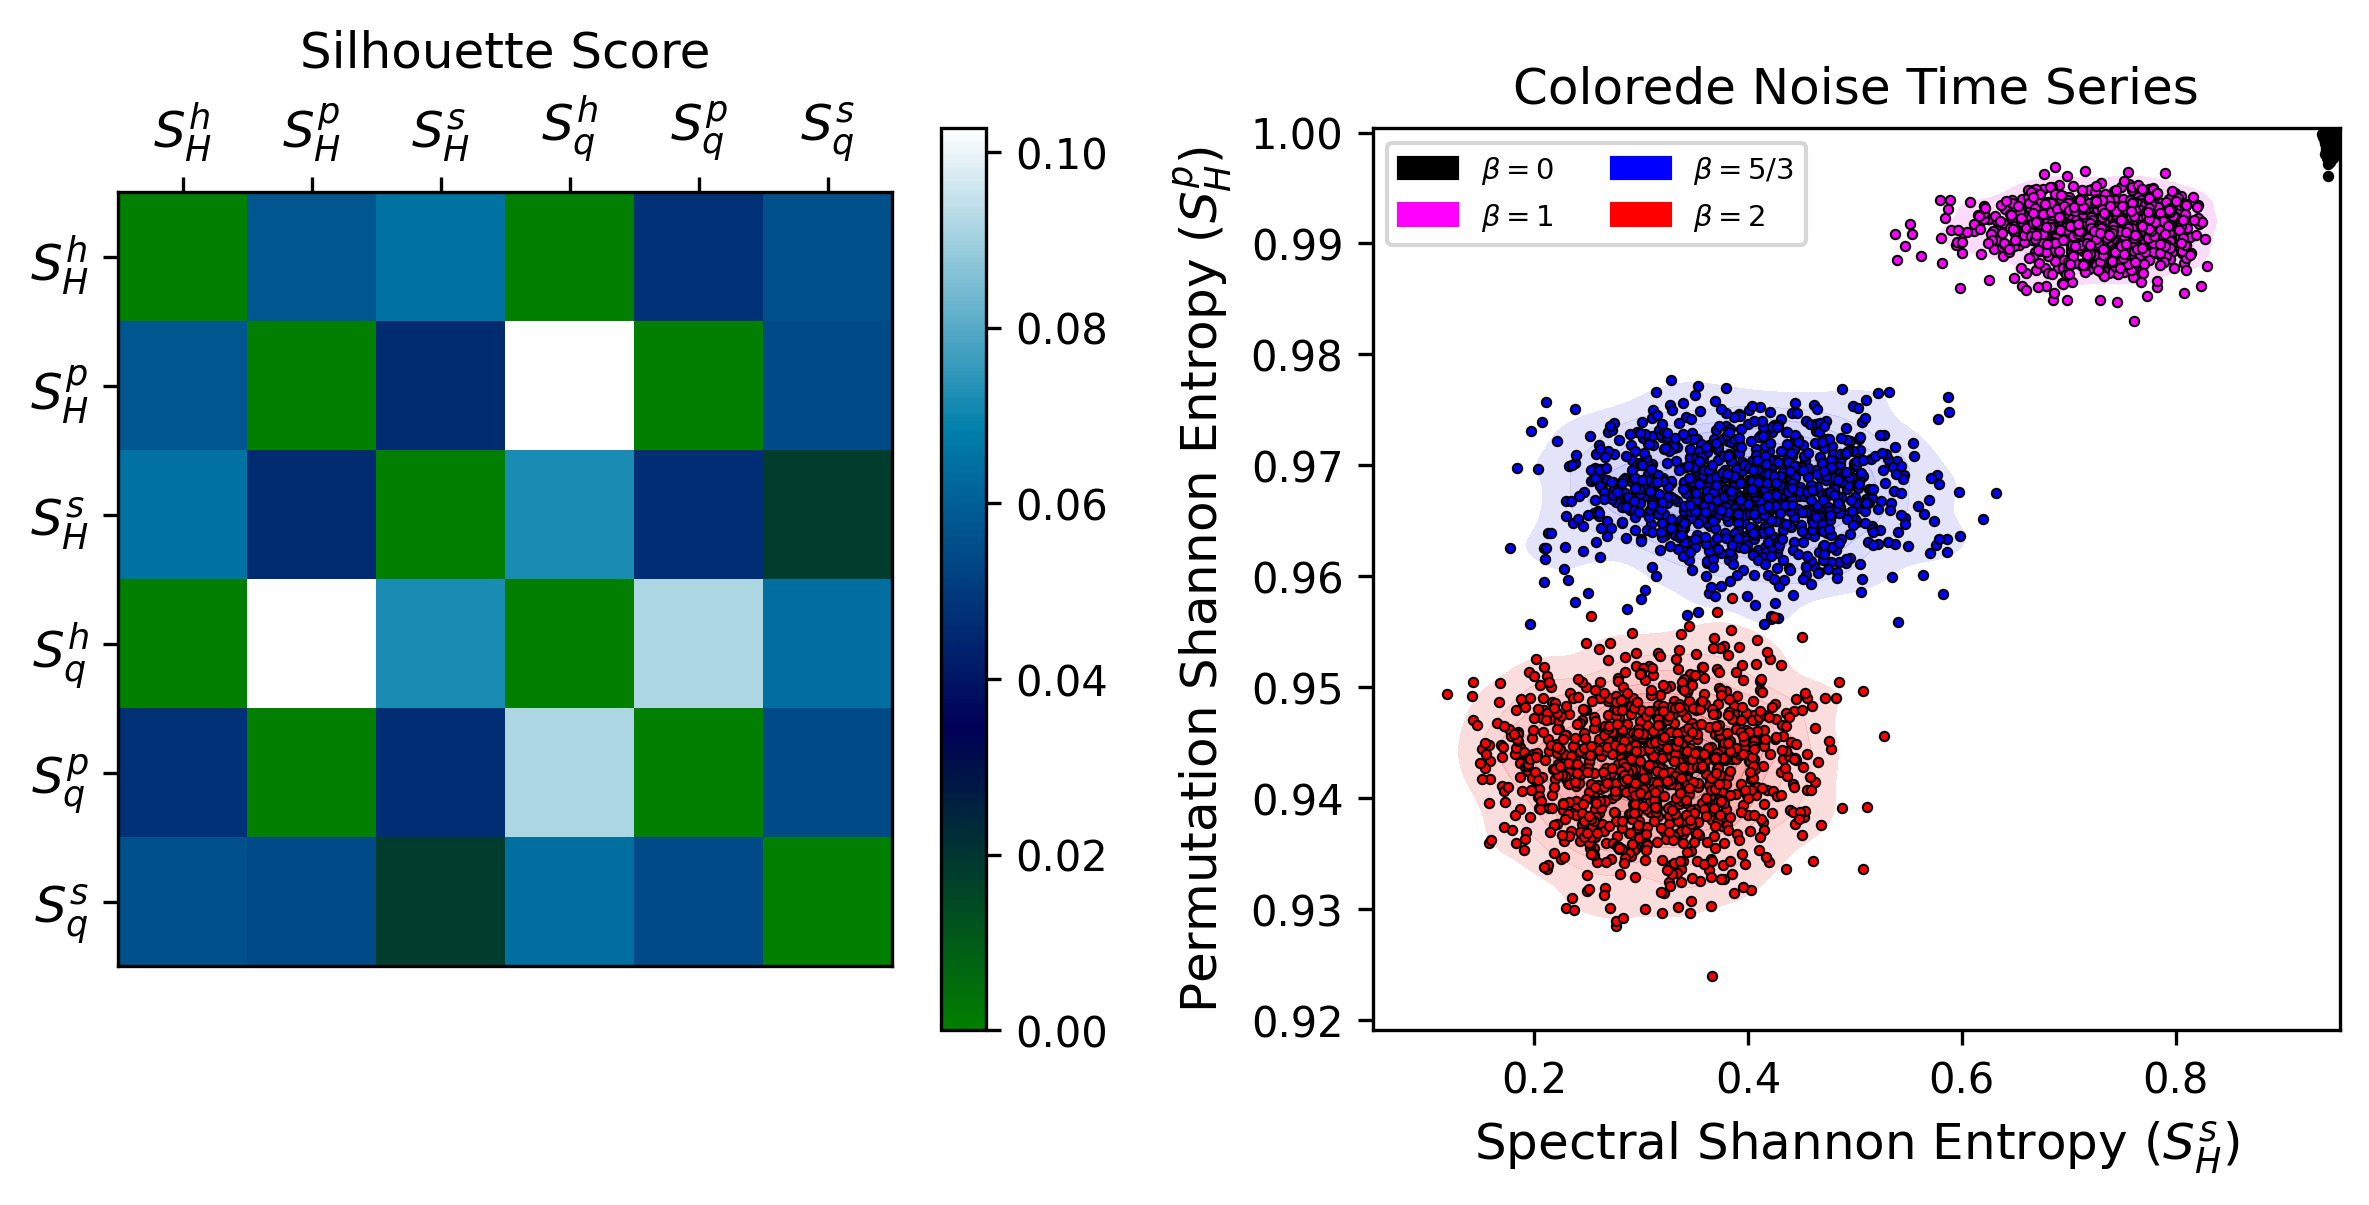

In [ ]:
plt.figure(figsize=(8, 4), dpi=300)

ax1 = plt.subplot(1, 2, 1)
plot_silhouette_score(scores_colored_noise, ax=ax1, cmap='ocean')
ax1.set_title("Silhouette Score")

ax2 = plt.subplot(1, 2, 2)
plot_one_pair(dataset_colored, ax=ax2, colors=colors_colores_noise, class_names=class_names_colores_noise, names_x=names_x, names_y=names_y, fontsize=12)
ax2.set_title("Colorede Noise Time Series")
plt.tight_layout()

plt.savefig(f'{save_path}Silhueta_colored_noise.pdf',dpi=300)
plt.savefig(f'{save_path}Silhueta_colored_noise.png',dpi=100)

plt.show()

In [ ]:
print(gerar_tabela_latex(dataset_colored,class_names_colores_noise))

\begin{table}[!ht]\label{tab:dataset}
\caption{}
  \begin{center}
    \begin{tabular}{l c c c c}
      \hline
\textbf{Coluna} & \textbf{$\beta = 0$}  & \textbf{$\beta = 1$}  & \textbf{$\beta = 5/3$}  & \textbf{$\beta = 2$} \\ \midrule
$S^h_H$ & 0.8954 ± 0.012 & 0.9032 ± 0.0124 & 0.9382 ± 0.015 & 0.9476 ± 0.0144\\
$S^p_H$ & 0.9995 ± 0.0004 & 0.9913 ± 0.002 & 0.9674 ± 0.004 & 0.9428 ± 0.0052\\
$S^s_H$ & 0.9445 ± 0.0022 & 0.7299 ± 0.0501 & 0.3971 ± 0.0809 & 0.3123 ± 0.0731\\
$S^h_q$ & -1.7421 ± 0.005 & -1.7453 ± 0.0052 & -1.7593 ± 0.0061 & -1.7627 ± 0.006\\
$S^p_q$ & -1.274 ± 0.0003 & -1.2677 ± 0.0015 & -1.2493 ± 0.0031 & -1.23 ± 0.0041\\
$S^s_q$ & -1.8726 ± 0.0007 & -1.7657 ± 0.0381 & -1.4627 ± 0.1311 & -1.3396 ± 0.1535\\
      \hline
    \end{tabular}
  \end{center}
\end{table}


# 2D Colored Noise

In [ ]:
df_data_all =  pd.read_pickle('/home/barauna/MEGA/Academia\/DOUTORADO/Tese/data/MultipleCNN_Noise.plk')
df_data_all2 =  pd.read_pickle('/home/barauna/MEGA/Academia/DOUTORADO/Tese/data/MultipleCNN_Noise2.plk')

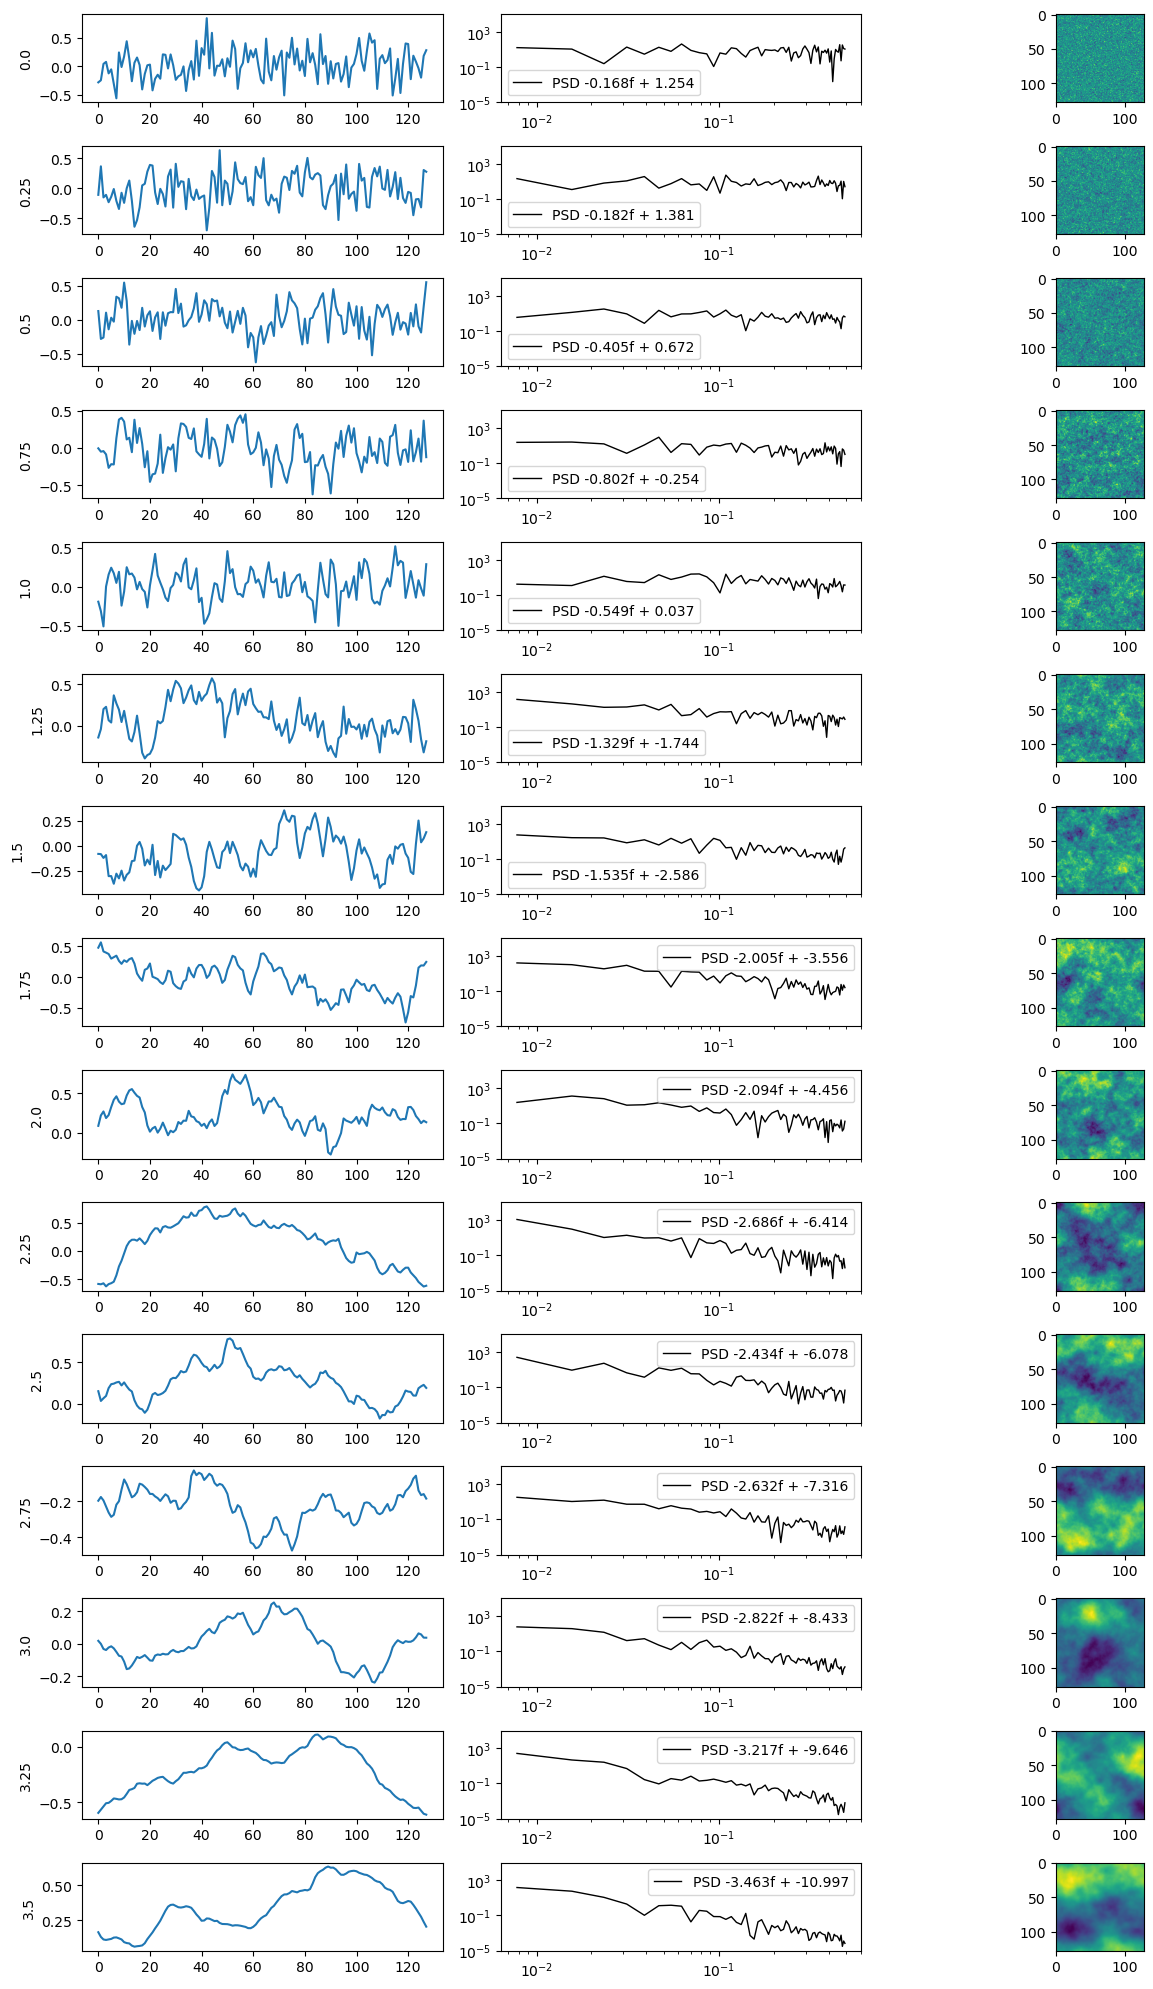

In [ ]:
plt.figure(figsize = (13,20))

chosed_len = 15

for i in range(chosed_len):
   plt.subplot(chosed_len,3,3*i+1)
   plt.plot(df_data_all['image'][i][0])
   plt.ylabel(df_data_all['class'][i])

   plt.subplot(chosed_len,3,3*i+2)
   plot_psd(df_data_all['image'][i][0])
   plt.ylim(1e-5,1e5)
   plt.legend()

   plt.subplot(chosed_len,3,3*i+3)
   #plt.title('β = '+str(df_data_all['class'][i]))
   plt.imshow(df_data_all['image'][i])
plt.tight_layout()

In [ ]:
len(df_data_all['image'][i])
df_data_all['class'][0]
noise_2d_b0 = df_data_all['image'][0]
noise_2d_b1 = df_data_all['image'][4]
noise_2d_b53 = df_data_all['image'][7]
noise_2d_b2 = df_data_all['image'][8]
noise_2d_all = [noise_2d_b0,noise_2d_b1,noise_2d_b53,noise_2d_b2]

In [ ]:
data_2d_noise = []
for i in range(len(noise_2d_all)):
  data_2d_noise.append(df_entropys(noise_2d_all[i],GPA=False,nx=2,ny=2))


In [ ]:
def df_GPAs(data):
    ga = GPA(0.0)
    df_data = []
    for i in tqdm.tqdm(range(len(data))):
        s = data[i]
        GPAs = ga(s,moment=['G1','G2','G3'])
        GPAs['G4'] = np.real(np.absolute(ga(s,moment=['G4'])['G4']))
        df_data.append(GPAs)
    return pd.DataFrame(df_data)

df_data = []
s = noise_2d_b53
GPAs = ga(s,moment=['G1','G2','G3'])
GPAs['G4'] = np.real(np.absolute(ga(s,moment=['G4'])['G4']))
df_data.append(GPAs)



In [ ]:
df_data

[{'G1': 0.004849236699086528,
  'G2': 0.9988930197385608,
  'G3': 0.7487544620085029,
  'G4': 1.0004228348360351}]

100%|██████████| 128/128 [00:01<00:00, 127.68it/s]


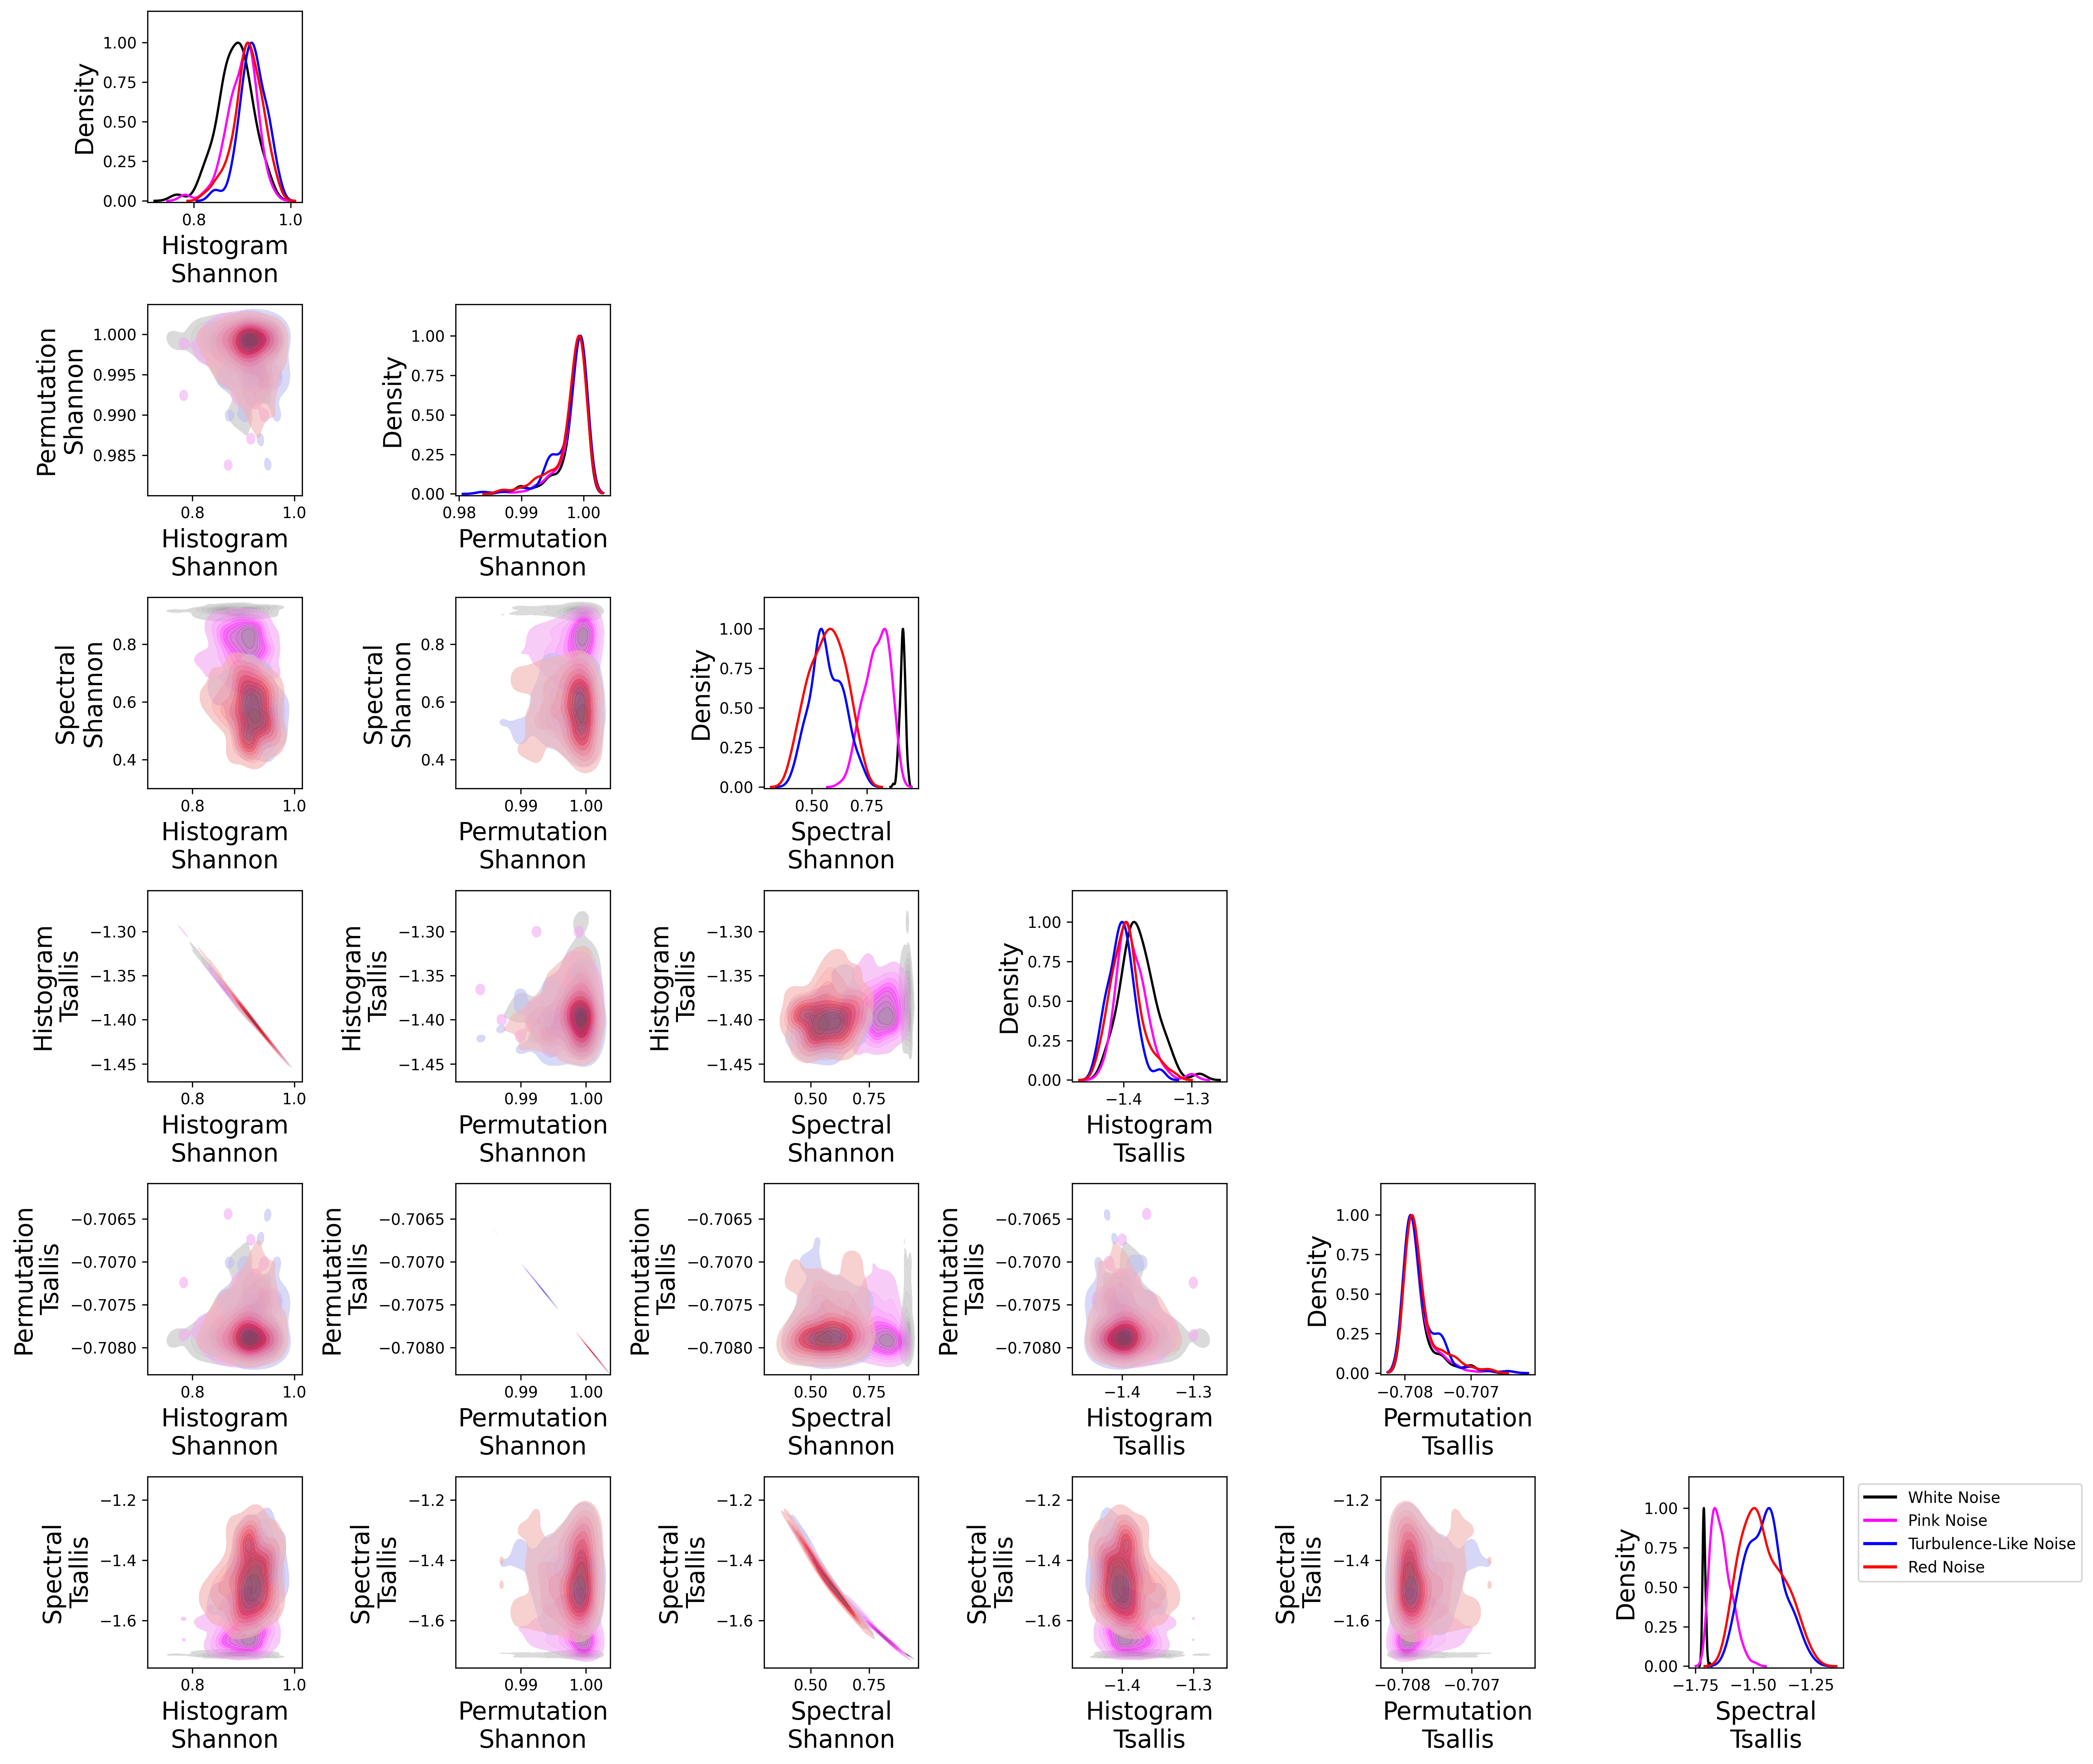

In [ ]:

selected_classes_name = ['White Noise',"Pink Noise","Turbulence-Like Noise","Red Noise"]
colors_colores_noise = ['black', 'magenta', 'blue', 'red']
fig = plt.figure(figsize=(19, 16), dpi=300)
fontsize= 16
triangle_kdeplot(data_2d_noise,colors=colors_colores_noise,class_names=selected_classes_name,fontsize=fontsize,fill =True, alpha = 0.6)
# img_positions = [(0.55, .75), (0.75, .75), (0.55, .53),  (0.75, .53)]
# Width, Height = 0.2, 0.2
# for k in range(4):
#     ax_img = fig.add_axes([img_positions[k][0], img_positions[k][1], Width, Height])
#     ax_img.imshow(selected_classes_image_color[k][1])
#     ax_img.set_title(selected_classes_name[k], fontsize=fontsize)
#     ax_img.axis('off')

plt.tight_layout()

save_imagens_path = "/home/veronica/MEGA/Academia/DOUTORADO/Tese/figuras/"
# plt.savefig(f'{save_imagens_path}triangle_KDE_2D_coloredNoise_dx2.png', dpi=100)
# plt.savefig(f'{save_imagens_path}triangle_KDE_visible_galxies.pdf', dpi=300)
plt.show()

('Permutation_PowerlawTsallis', 'Spectral_Shannon') with score 0.2646384635456575


<Figure size 1500x1200 with 0 Axes>

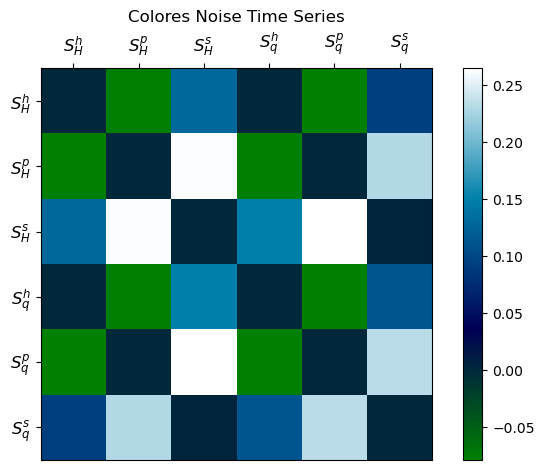

In [ ]:
scores_colored_noise = silhouette_score(data_2d_noise,prin_best_correlation=True)

plt.figure(figsize=(5,4),dpi=300)
plot_silhouette_score(scores_colored_noise,cmap='ocean')
plt.title("Colores Noise Time Series")
plt.tight_layout()
save_path = "/home/veronica/MEGA/Academia/DOUTORADO/Tese/figuras/"
# plt.savefig(f'{save_path}Silhueta_colored_noise.pdf',dpi=300)
plt.savefig(f'{save_path}Silhueta_2D_colored_noise.png',dpi=100)
plt.show()

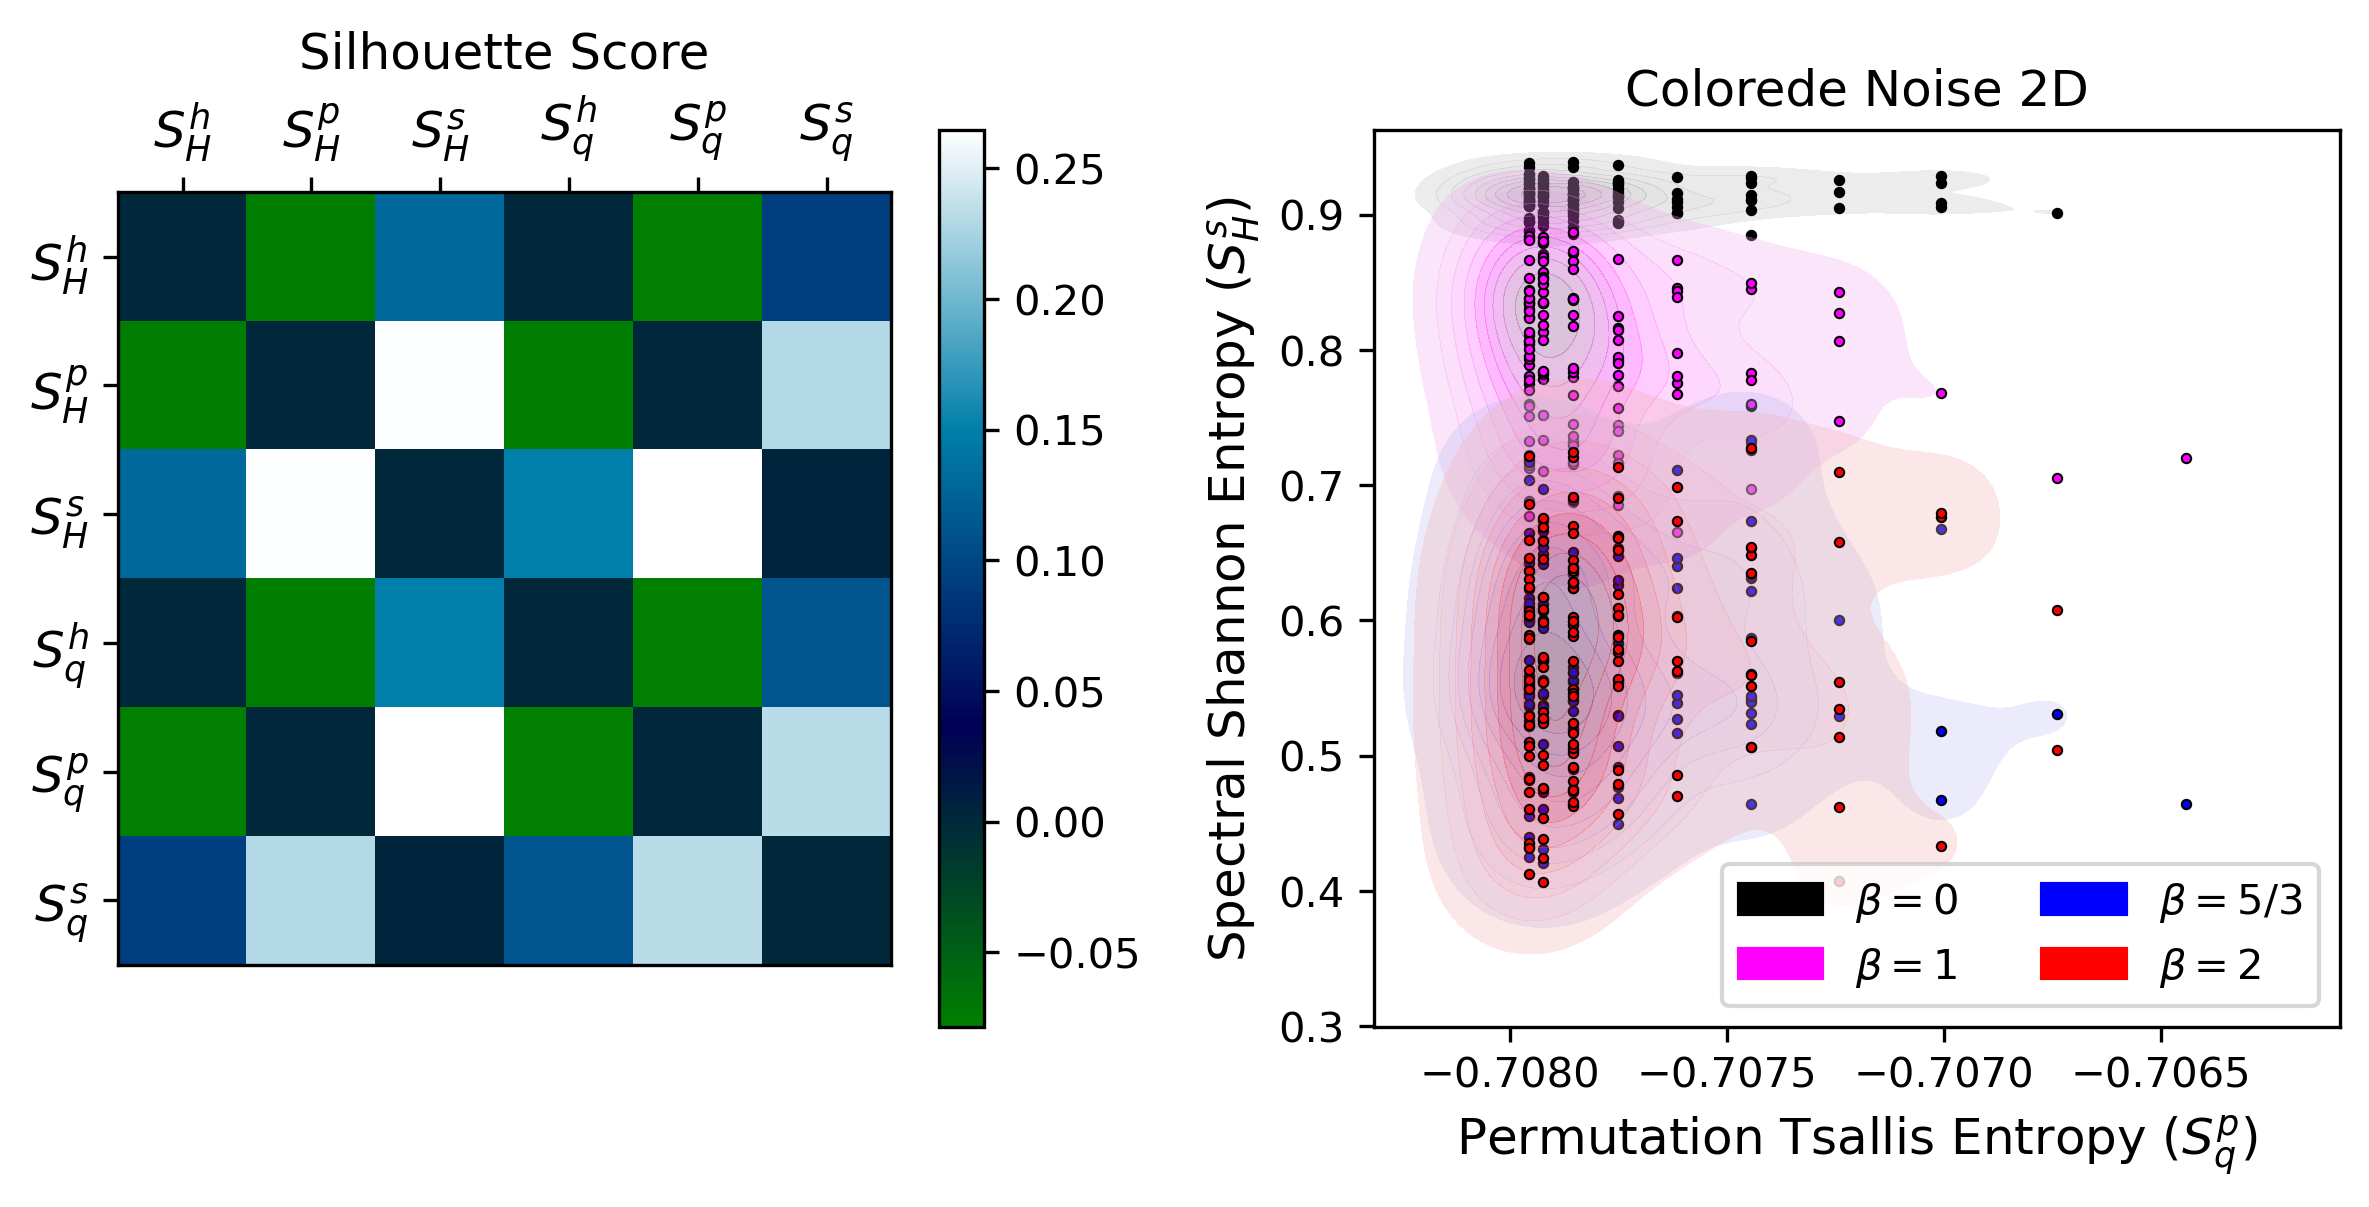

In [ ]:
plt.figure(figsize=(8, 4), dpi=300)

names_x = silhouette_score(data_2d_noise,return_best_pair=True)[0]
names_y = silhouette_score(data_2d_noise,return_best_pair=True)[1]
class_names_colores_noise = ['$\\beta = 0$', '$\\beta = 1$', '$\\beta = 5/3$', '$\\beta = 2$']
ax1 = plt.subplot(1, 2, 1)
plot_silhouette_score(scores_colored_noise, ax=ax1, cmap='ocean')
ax1.set_title("Silhouette Score")

ax2 = plt.subplot(1, 2, 2)
plot_one_pair(data_2d_noise, ax=ax2, colors=colors_colores_noise, class_names=class_names_colores_noise, names_x=names_x, names_y=names_y, fontsize=12)
ax2.set_title("Colorede Noise 2D")
plt.tight_layout()

# plt.savefig(f'{save_path}Silhueta_colored_noise.pdf',dpi=300)
plt.savefig(f'{save_path}Silhueta_2Dcolored_noise.png',dpi=100)

plt.show()


```
Galaxy10 dataset (17736 images)
├── Class 0 (1081 images): Disturbed Galaxies
├── Class 1 (1853 images): Merging Galaxies
├── Class 2 (2645 images): Round Smooth Galaxies
├── Class 3 (2027 images): In-between Round Smooth Galaxies
├── Class 4 ( 334 images): Cigar Shaped Smooth Galaxies
├── Class 5 (2043 images): Barred Spiral Galaxies
├── Class 6 (1829 images): Unbarred Tight Spiral Galaxies
├── Class 7 (2628 images): Unbarred Loose Spiral Galaxies
├── Class 8 (1423 images): Edge-on Galaxies without Bulge
└── Class 9 (1873 images): Edge-on Galaxies with Bulge

# Hidrodinamical Simulations

## Data

### Data Mining

In [ ]:
# start_time = time.time()

# # !gdown --folder "https://drive.google.com/drive/u/1/folders/1e3I2daEFfOgOsDaFU4hiON-OjsjyOjul" --output "./data"

# # Taylor-Green re=1800 grid=128 data=vorticity:
# !gdown --folder "https://drive.google.com/drive/u/1/folders/1YJ6Uf6UZFg0Mkr7akOtpZQQp0ykdPHN7" --output "./Taylor-Green_re_1800_grid_128_data_vorticity"

# # Wavenumber_forcing=456 re=10 grid=128 data=vorticity:
# !gdown --folder "https://drive.google.com/drive/u/1/folders/1xnsT5TDjzDMCpBU1jGk_3RdrMXLalC1z" --output "./Wavenumber_forcing_456_re_10_grid_128_data_vorticity"

# # Wavenumber_forcing=456 re=20 grid=128 data=velocity:
# !gdown --folder "https://drive.google.com/drive/u/1/folders/1e3I2daEFfOgOsDaFU4hiON-OjsjyOjul" --output "./Wavenumber_forcing_456_re_20_grid=128_data_velocity"

# # Wavenumber_forcing=456 re=20 grid=128 data=vorticity:
# !gdown --folder "https://drive.google.com/drive/u/1/folders/1VoSKG2Gc9HG1MA3PG0OWkSi5jrcKV6Zt" --output "./Wavenumber_forcing=456_re=20_grid=128_data=vorticity"

# # Wavenumber_forcing=456 re=100 grid=128 data=vorticity:
# !gdown --folder "https://drive.google.com/drive/u/1/folders/1TQ9-EHxIN5mFl6Nc_QDlWP7O5BwHAPs_" --output "./Wavenumber_forcing_456_re_100_grid_128_data_vorticity"

# # Wavenumber_forcing=456 re=1800 grid=128 data=vorticity:
# !gdown --folder "https://drive.google.com/drive/u/1/folders/1ZJ3ltK8ruUnkVEilpIo_AWVQ4uSq2Rlm" --output "./Wavenumber_forcing_456_re_1800_grid_128_data_vorticity"

# # Extra:

# # Taylor-Green re=1800 grid=128 data=vorticity:
# !gdown --folder "https://drive.google.com/drive/u/1/folders/1FM2mlZ_5V2wNSIdv7XfNlJEXDKQYAyQY" --output "./Taylor-Green_re_1800_grid_128_data_vorticity"

# Wavenumber_forcing=456 re=1800 grid=128 data=vorticity:
# !gdown --folder "https://drive.google.com/drive/u/1/folders/1UjHjZaeueYcZqWQEp9Mti-CFFGeoeRgD" --output "./Wavenumber_forcing_456_re_1800_grid_128_data_vorticity"

# print(time.time()-start_time)

In [ ]:
# # Taylor-Green re=1800 grid=128 data=vorticity:
!gdown --folder "https://drive.google.com/drive/u/1/folders/1FM2mlZ_5V2wNSIdv7XfNlJEXDKQYAyQY" --output "./Taylor-Green_re_1800_grid_128_data_vorticity"


Retrieving folder contents
Retrieving folder 1-Q4McvS63Blz8e8DAHcBqVzOqlrCHD9M .ipynb_checkpoints
Processing file 1-QWgIacwxtHjkE4z_mbKP9IBG5G41Bi8 curl_n_0.npy
Processing file 1-RhJE13Dk9MTeJPL_ArbMGipPURBgIie curl_n_400.npy
Processing file 1-Wh3dYussAcuAgcqak9XVaC1yCoKTM_q curl_n_800.npy
Processing file 1-lu-QvDKmavV1tfN3ghLFFohZcifWB_l curl_n_1200.npy
Processing file 1-u8RQHu0QtY8c-PSIYN8wk4OkXD9Ghyj curl_n_1600.npy
Processing file 10-XUZ_RbUnFrOnNQtJMBdxItHds5SdqT curl_n_2000.npy
Processing file 1025x3HhNAEp_xmGv-ieewFxYXPNWF9bq curl_n_2400.npy
Processing file 103agROnMvTZpWbGqsiJdaYqAEgCRMxWb curl_n_2800.npy
Processing file 104_zNXZqhD7mgOOUtrhwvUptQ1qk5oMh curl_n_3200.npy
Processing file 108ox4VxmPWebt3Z5tL_KVrVAI4uDYsFh curl_n_3600.npy
Processing file 10ADMuAg2eYP5xxtUgLzz9Ah_2pFYorto curl_n_4000.npy
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1-QWgIacwxtHjkE4z_mbKP9I

In [ ]:
# # Wavenumber_forcing=456 re=1800 grid=128 data=vorticity:
!gdown --folder "https://drive.google.com/drive/u/1/folders/1ZJ3ltK8ruUnkVEilpIo_AWVQ4uSq2Rlm" --output "./Wavenumber_forcing_456_re_1800_grid_128_data_vorticity"


Retrieving folder contents
Processing file 19ssnm7ohaJNE5irj_OfWClXxvS_gYPwY curl_n_0.npy
Processing file 1A2sGMvTmKXynERGq2XmyupgvW_8mbFA4 curl_n_27.npy
Processing file 1A3fhMoYksDObXJ-fObb3vdoQbZ3TTdZ9 curl_n_54.npy
Processing file 1AEODvkV4UYtnm9vBg9LPmABPrgzJthuL curl_n_81.npy
Processing file 1AFID795x_joGW-XWLS2QVCfuVAmY8Ydx curl_n_108.npy
Processing file 1AGnDWTXm5k-ev4spJtINbT_NLcF046M0 curl_n_135.npy
Processing file 1AHWf7JfngIEsdgUUvvbb1Gad_e8suzTK curl_n_162.npy
Processing file 1AKkWz2uG7WJMuU-WwAfSzIO1hBlxDY3x curl_n_189.npy
Processing file 1AR3L3Q8hjZ5WFG5pi3Fm7FCYQzSV1otX curl_n_216.npy
Processing file 1ASRL4FhmPrsj5KGj1uTnx70KVpVKVbx- curl_n_243.npy
Processing file 1ASSlNThCNYttr4Ht1bjq8Yj815hslGCh curl_n_270.npy
Processing file 1A_dKNr2cXNXZncAL5L-XckVLDFl5VaMW curl_n_297.npy
Processing file 1AaMiRjN-m-5J7Bg0W7VRwwqsh-eg2RA6 curl_n_324.npy
Processing file 1Ab8VZnTGjv6pcYmNnxmFe47ocRG8WV-b curl_n_351.npy
Processing file 1AbeFBebmWSk85pFsIDkoZYz7wwVjRCnE curl_n_378.npy
Pro

In [ ]:
# Wavenumber_forcing=456 re=20 grid=128 data=velocity:
!gdown --folder "https://drive.google.com/drive/u/1/folders/1e3I2daEFfOgOsDaFU4hiON-OjsjyOjul" --output "./Wavenumber_forcing_456_re_20_grid=128_data_velocity"


Retrieving folder contents
Processing file 1IM0UyMjPolYR6EW8mnW7qz9uU-fYgbl4 U_0.npy
Processing file 1rh8JkB7n_Px0T8G4LebmfQIVpqnPWJkI U_1250.npy
Processing file 1Id_TCOc8ebgVwp3M5wz4fKxPhojotIMT U_2500.npy
Processing file 1yBZpgFi5zYX5hgjMyaly9jq-3YsVVXZs U_3750.npy
Processing file 1XELlZJADD8-k6rqJ_tC-QG-EauR1knT1 U_5000.npy
Processing file 1DtJGgP_KLdyZmAhZJzfo6KqmY0yY1y8P U_6250.npy
Processing file 1UoZCbCL9aPHYUNiJBVwokeFhKnOOysGA U_7500.npy
Processing file 1UUrLv5odw1uYfyLw03bIonRyV-zP2sfe U_8750.npy
Processing file 10rql2bINPxQ2F0uU5Y557s-fMhqlMEXt U_10000.npy
Processing file 1KIgDyb1d7wU_zhlG-iJl2mD80SBoLo17 U_11250.npy
Processing file 1U5f-KcoxvnnzFqncQsCZphS4SLAIShDR U_12500.npy
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github

In [ ]:
ls

 drive-download-20250530T115703Z-1-001.zip
 sample_data/
 Slices.zip
 Taylor-Green_re_1800_grid_128_data_vorticity/
 Wavenumber_forcing_456_re_1800_grid_128_data_vorticity/
'Wavenumber_forcing_456_re_20_grid=128_data_velocity'/


In [ ]:
!unzip "drive-download-20250530T115703Z-1-001.zip" -d "./Wavenumber_forcing_456_re_20_grid=128_data_velocity"


Archive:  drive-download-20250530T115703Z-1-001.zip
  inflating: ./Wavenumber_forcing_456_re_20_grid=128_data_velocity/U_10000.npy  
  inflating: ./Wavenumber_forcing_456_re_20_grid=128_data_velocity/U_6250.npy  
  inflating: ./Wavenumber_forcing_456_re_20_grid=128_data_velocity/U_11250.npy  
  inflating: ./Wavenumber_forcing_456_re_20_grid=128_data_velocity/U_2500.npy  
  inflating: ./Wavenumber_forcing_456_re_20_grid=128_data_velocity/U_12500.npy  
  inflating: ./Wavenumber_forcing_456_re_20_grid=128_data_velocity/U_1250.npy  
  inflating: ./Wavenumber_forcing_456_re_20_grid=128_data_velocity/U_7500.npy  
  inflating: ./Wavenumber_forcing_456_re_20_grid=128_data_velocity/U_8750.npy  
  inflating: ./Wavenumber_forcing_456_re_20_grid=128_data_velocity/U_3750.npy  
  inflating: ./Wavenumber_forcing_456_re_20_grid=128_data_velocity/U_0.npy  
  inflating: ./Wavenumber_forcing_456_re_20_grid=128_data_velocity/U_5000.npy  


### Load Data

In [ ]:
# Existem várias pastas que foram baixadas na raiz.
#Existem algumas pastas que não são relavantes para a nossa analise e foram
#retiradas

folders = os.listdir('./')
# remove folders '.config' and 'sample_data'
folders = [folder for folder in folders if folder not in ['.config', 'sample_data']]
folders

['Taylor-Green_re_1800_grid_128_data_vorticity',
 'Wavenumber_forcing_456_re_20_grid=128_data_velocity',
 'drive-download-20250530T115703Z-1-001.zip',
 '.ipynb_checkpoints',
 'Slices.zip',
 'Wavenumber_forcing_456_re_1800_grid_128_data_vorticity']

In [ ]:
#Print in npy_files in crescent order
npy_files = [f for f in os.listdir('./Wavenumber_forcing_456_re_20_grid=128_data_velocity') if f.endswith('.npy')]
# Ordenar pela parte numérica
npy_files = sorted(npy_files, key=lambda x: int(x.split('_')[1].split('.')[0]))
npy_files

['U_0.npy',
 'U_1250.npy',
 'U_2500.npy',
 'U_3750.npy',
 'U_5000.npy',
 'U_6250.npy',
 'U_7500.npy',
 'U_8750.npy',
 'U_10000.npy',
 'U_11250.npy',
 'U_12500.npy']

In [ ]:
folders[5]

'Wavenumber_forcing_456_re_1800_grid_128_data_vorticity'

In [ ]:
# Aqui estamos carregando todos os aquivos .npy que esta em uma das pastas
# baixadas. Dessa forma realizaremos uma recorrencia na analise

import os
import numpy as np

folder = "/content/" + "Wavenumber_forcing_456_re_20_grid=128_data_velocity" #folders[5]
npy_files = [f for f in os.listdir(folder) if f.endswith('.npy')]
# Ordenar pela parte numérica
npy_files = sorted(npy_files, key=lambda x: int(x.split('_')[1].split('.')[0]))
npy_file = npy_files[-1]

data_dict = {}
for file_name in npy_files:
    data_dict[file_name] = np.load(os.path.join(folder, file_name))

# Agora data_dict[file_name] tem o array carregado correspondente

data = data_dict[npy_file]

import numpy as np

amplitude = np.sqrt(np.sum(data**2, axis=0))  # Soma ao longo do eixo das componentes (x,y,z)

#Stride:
amplitude = amplitude[::2, ::2, ::2]

import matplotlib.pyplot as plt
framesX, framesY, framesZ = [],[],[]
#  Pega o slice central no eixo z
for x in range(len(amplitude)):
  frameX = amplitude[x, :, :]
  framesX.append(frameX)
  frameY = amplitude[:, x, :]
  framesY.append(frameY)
  frameZ = amplitude[:, :, x]
  framesZ.append(frameZ)

### Data Vizualization

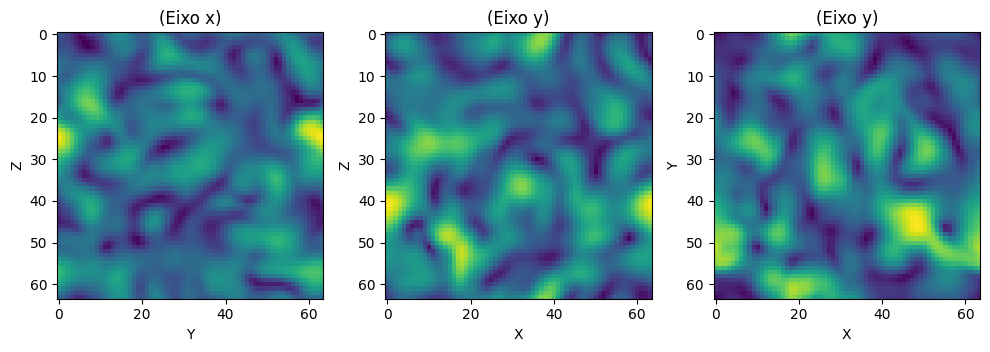

In [ ]:
frame = 10
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(framesX[frame], cmap='viridis')  # Você pode mudar o cmap se quiser
# plt.colorbar(label='Amplitude')
plt.title('(Eixo x)')
plt.xlabel('Y')
plt.ylabel('Z')

plt.subplot(1, 3, 2)
plt.imshow(framesY[frame], cmap='viridis')  # Você pode mudar o cmap se quiser
# plt.colorbar(label='Amplitude')
plt.title('(Eixo y)')
plt.xlabel('X')
plt.ylabel('Z')

plt.subplot(1, 3, 3)
plt.imshow(framesZ[frame], cmap='viridis')  # Você pode mudar o cmap se quiser
# plt.colorbar(label='Amplitude')
plt.title('(Eixo y)')
plt.xlabel('X')
plt.ylabel('Y')

plt.tight_layout()
plt.show()

## Pre-Processing

In [ ]:
dataset = [df_entropys(frameX,GPA=False),
          df_entropys(frameY,GPA=False),
          df_entropys(frameX,GPA=False)]

colors = ['red', 'green', 'blue']
class_names = ['X', 'Y', 'Z']

100%|██████████| 64/64 [00:00<00:00, 189.00it/s]


## Results

### Tabela em Latex

In [ ]:
print(gerar_tabela_latex(dataset, colors,round_media=3, round_std=3))

\begin{table}[!ht]\label{tab:dataset}
\caption{}
  \begin{center}
    \begin{tabular}{l c c c}
      \hline
\textbf{d} & \textbf{red}  & \textbf{green}  & \textbf{blue} \\ \midrule
$S^h_H$ & 0.94 ± 0.023 & 0.934 ± 0.027 & 0.94 ± 0.023\\
$S^p_H$ & 0.599 ± 0.027 & 0.609 ± 0.026 & 0.599 ± 0.027\\
$S^s_H$ & 0.519 ± 0.049 & 0.521 ± 0.044 & 0.519 ± 0.049\\
$S^h_q$ & -1.416 ± 0.016 & -1.412 ± 0.02 & -1.416 ± 0.016\\
$S^p_q$ & -0.925 ± 0.028 & -0.931 ± 0.025 & -0.925 ± 0.028\\
$S^s_q$ & -1.441 ± 0.06 & -1.444 ± 0.052 & -1.441 ± 0.06\\
      \hline
    \end{tabular}
  \end{center}
\end{table}


### Score de Silhueta

('Spectral_PowerlawTsallis', 'Spectral_Shannon') with score -0.00010082230950024575


<Figure size 1500x1200 with 0 Axes>

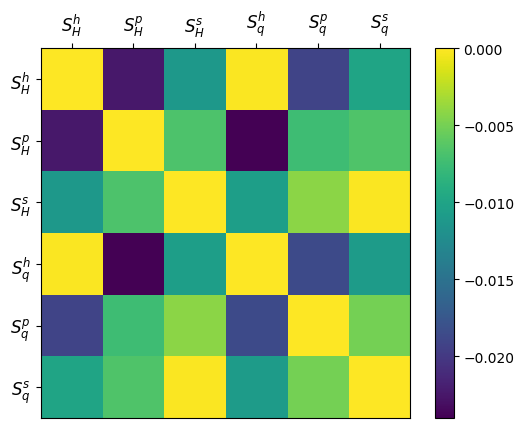

In [ ]:
plt.figure(figsize=(5,4),dpi=300)
scores = silhouette_score(dataset,prin_best_correlation=True)
plot_silhouette_score(scores,cmap="viridis")
# plt.savefig('Silhueta.pdf')
plt.show()

### Triangle Plote

In [ ]:
frames = [framesX,framesY,framesZ]

<ipython-input-324-e752b644c74b>:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


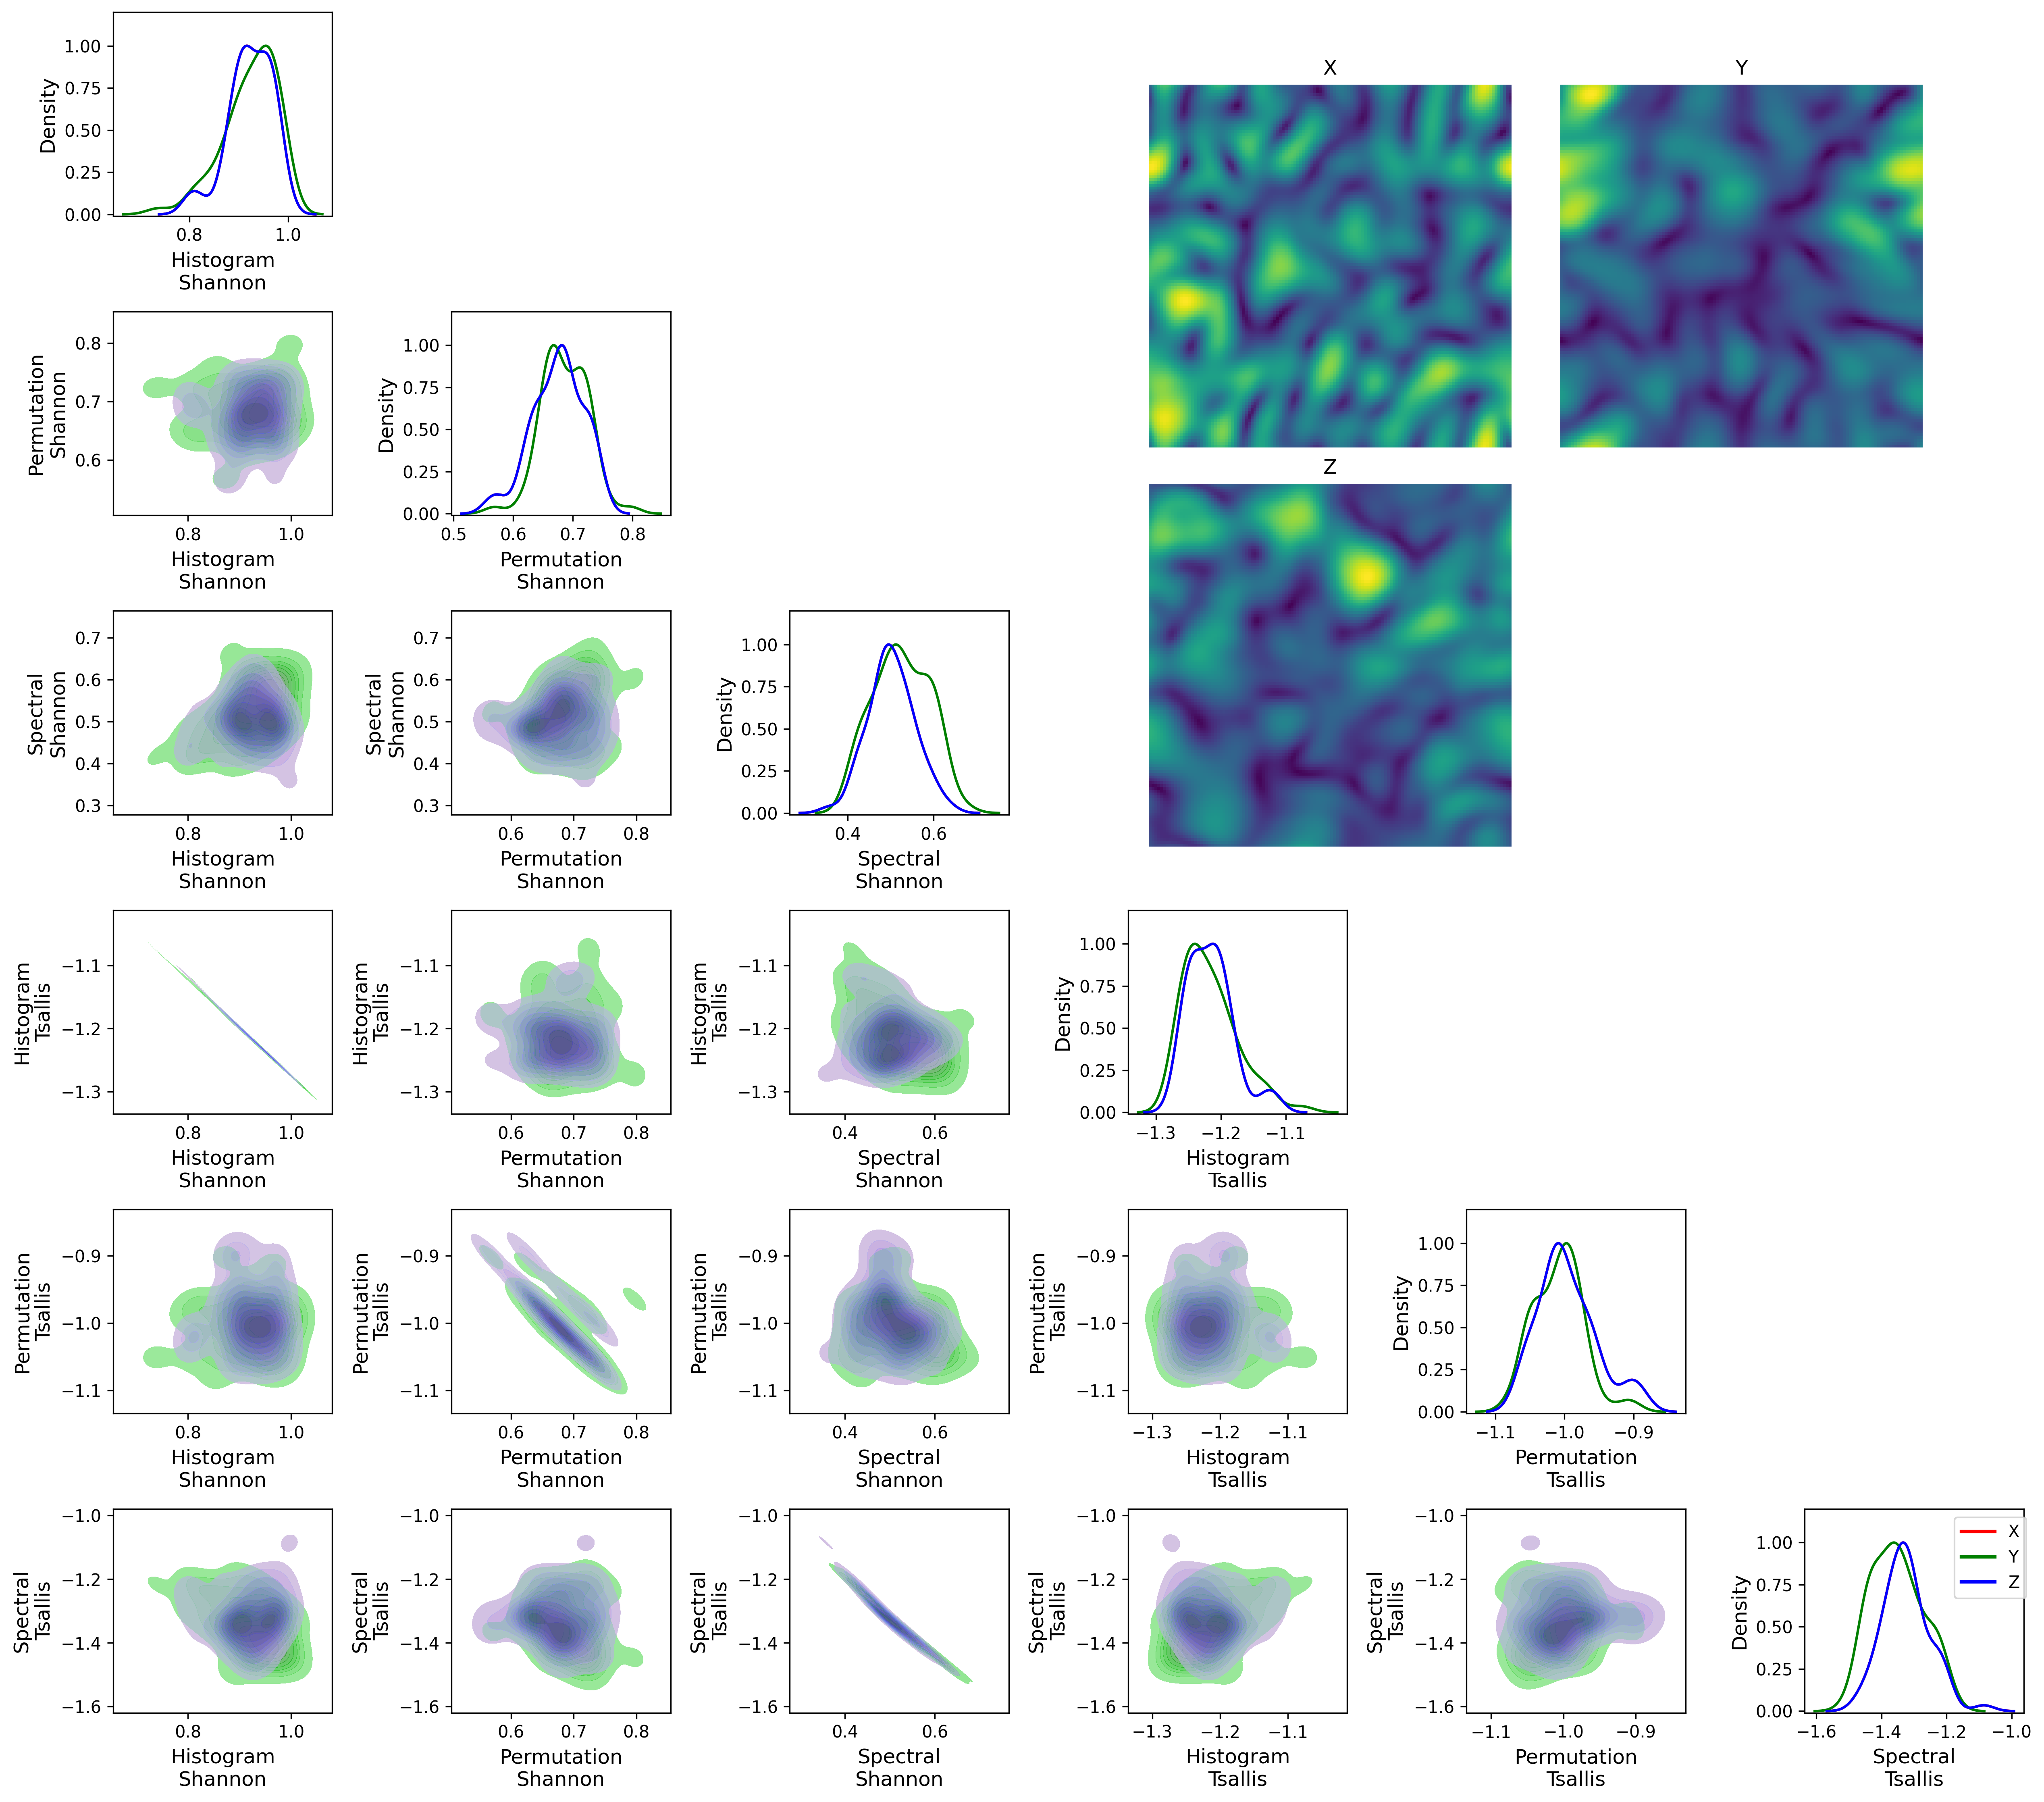

In [ ]:
fig = plt.figure(figsize=(17, 15), dpi=300)
fontsize = 12

triangle_kdeplot(dataset,colors,
                 class_names=class_names,
                 fontsize=fontsize,
                 fill =True, alpha = 0.6)

# Inserir imagens na parte inferior da figura
img_positions = [(0.55, .75), (0.75, .75), (0.55, .53),  (0.75, .53)]
Width, Height = 0.2, 0.2
for k in range(len(frames)):
    ax_img = fig.add_axes([img_positions[k][0], img_positions[k][1], Width, Height])
    ax_img.imshow(frames[k][100])
    ax_img.set_title(class_names[k], fontsize=fontsize)
    ax_img.axis('off')

plt.tight_layout()
save_imagens_path = "/home/barauna/MEGA/Academia/DOUTORADO/Tese/figuras/"
# plt.savefig(f'{save_imagens_path}triangle_KDEioxies.png', dpi=100)
# plt.savefig(f'{save_imagens_path}triangle_KDEioxies.pdf', dpi=300)
plt.show()

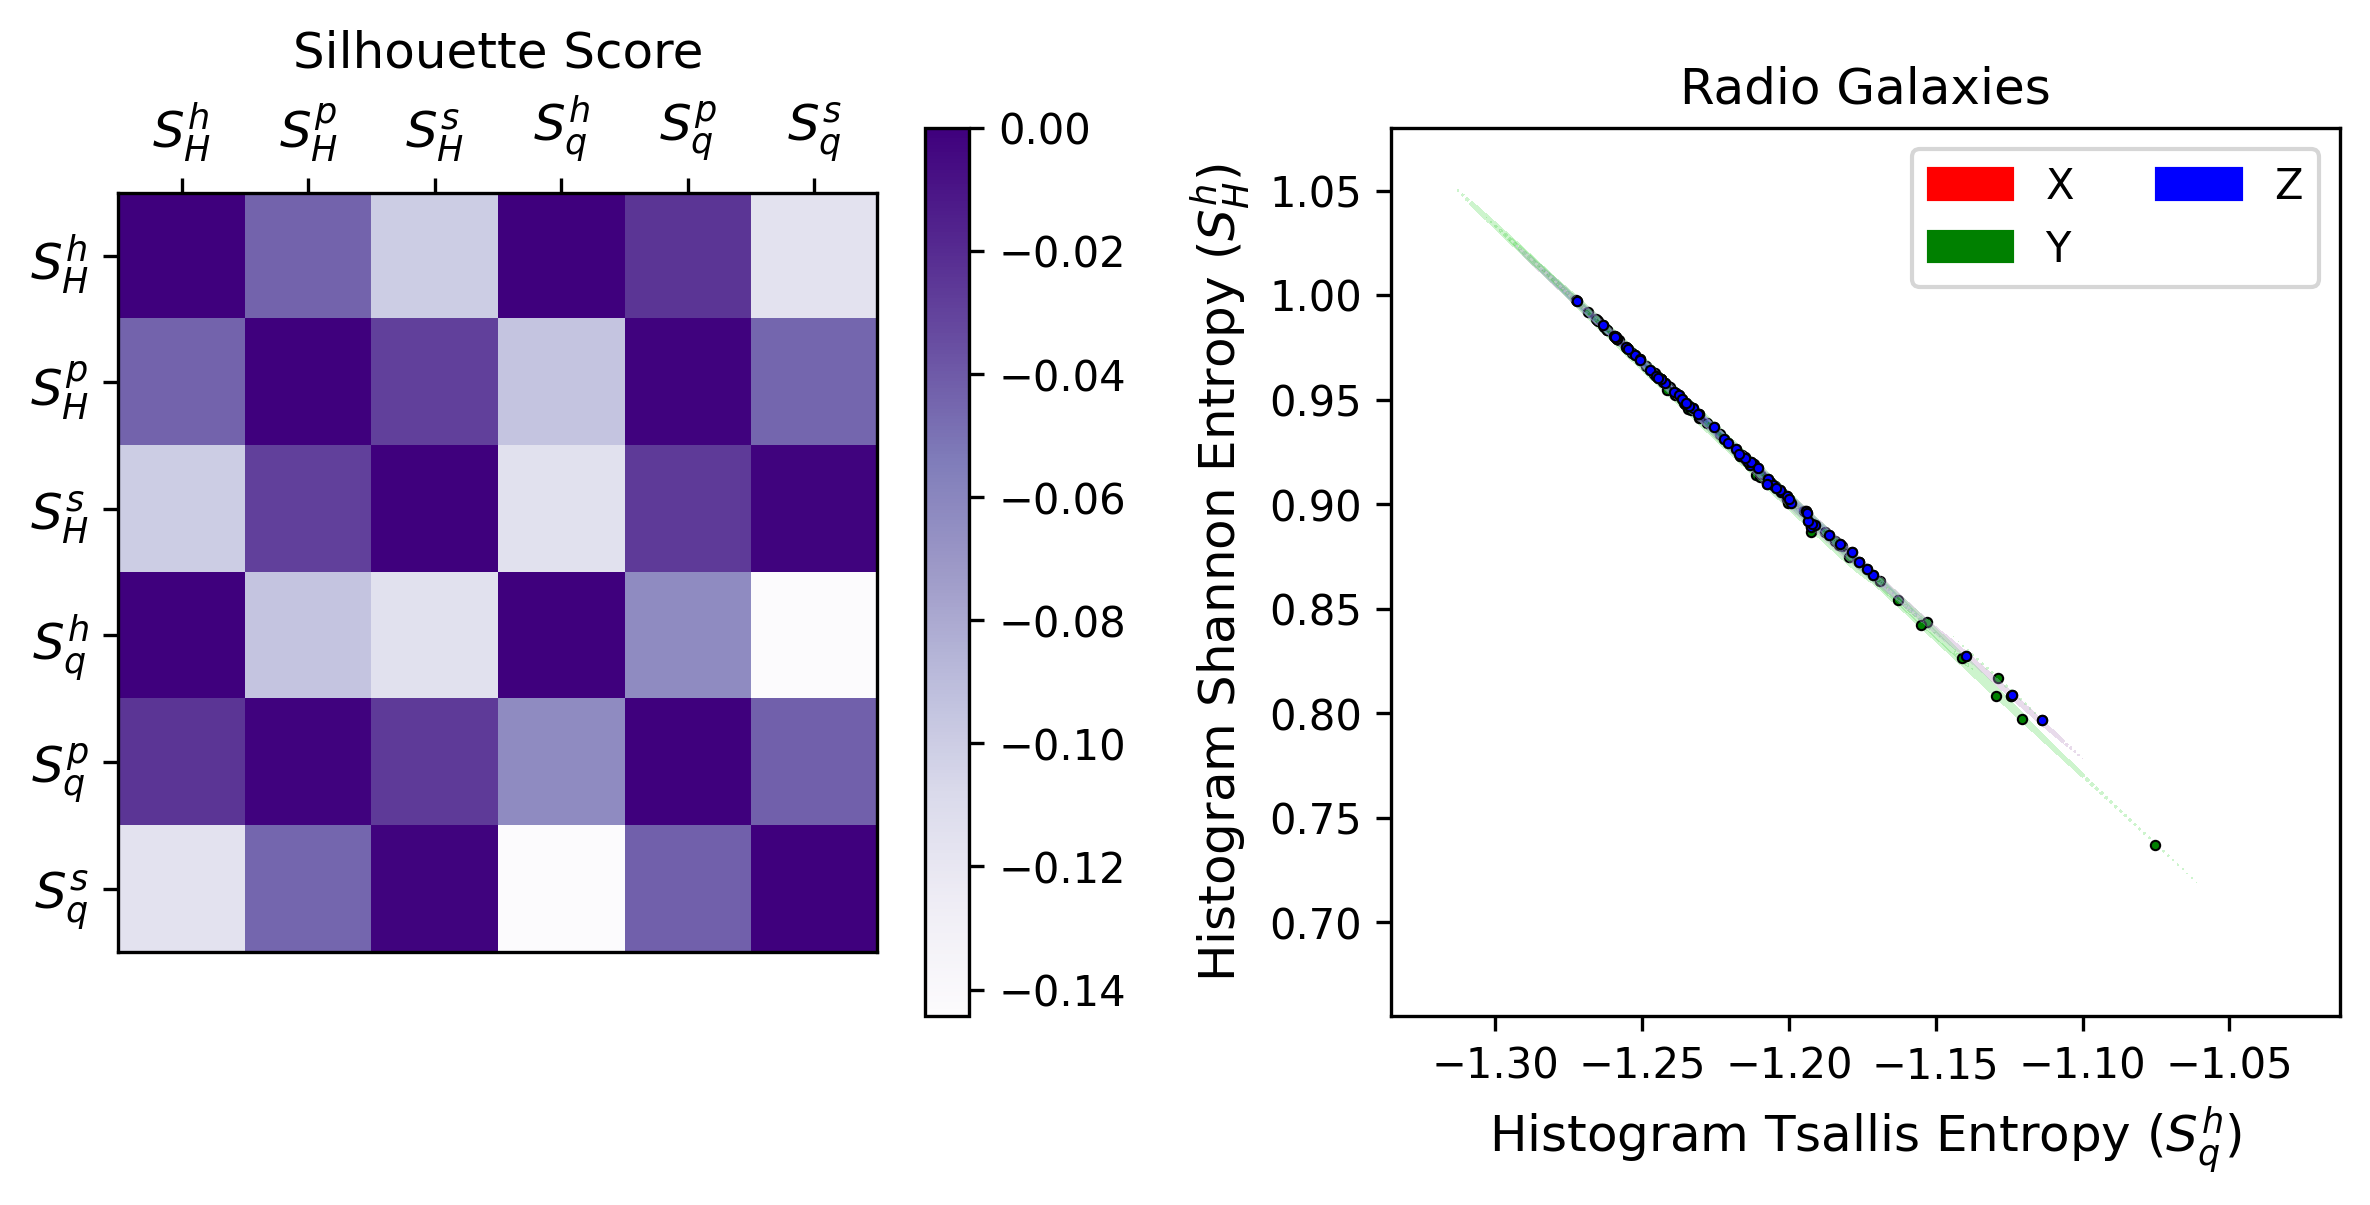

In [ ]:
plt.figure(figsize=(8, 4), dpi=300)

ax1 = plt.subplot(1, 2, 1)
plot_silhouette_score(scores, ax=ax1, cmap='Purples')
ax1.set_title("Silhouette Score")

ax2 = plt.subplot(1, 2, 2)
plot_one_pair(dataset, ax=ax2,
              colors=colors,
              class_names=class_names, fontsize=12)#, names_x=names_x, names_y=names_y)
ax2.set_title("Radio Galaxies")
plt.tight_layout()

# plt.savefig(f'{save_path}Silhueta.pdf',dpi=300)
# plt.savefig(f'{save_path}Silhueta.png',dpi=100)

plt.show()

# MHD (erico) vs Hidrodinamica

## Data

### Load Data - Hidro
Observe que o dado ja foi minerado na sessão anterior

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

folder = "/content/" + "Wavenumber_forcing_456_re_20_grid=128_data_velocity" #folders[5]

def read_files(folder,n_files=None):

  npy_files = [f for f in os.listdir(folder) if f.endswith('.npy')]
  try:
    npy_files = sorted(npy_files, key=lambda x: int(x.split('_')[1].split('.')[0]))
  except:
    pass
  if n_files is not None:
    last_files = npy_files[-n_files:]
  else:
    last_files = npy_files
  final_slices = []

  for file_name in last_files:
      data = np.load(os.path.join(folder, file_name))  # shape ex: (3,128,128) ou (3,128,128,128)

      amplitude = np.sqrt(np.sum(data**2, axis=0))  # shape (128,128)

      # Selecionar 11 fatias equidistantes no eixo 0 (tempo/profundidade)
      num_slices = 11
      axis0_size = amplitude.shape[0]
      indices = np.linspace(0, axis0_size - 1, num_slices).astype(int)

      selected_slices = amplitude[indices, :, :]  # (11,128,128)

      # Downsampling 2x nas dimensões XY
      downsampled = selected_slices[:, ::2, ::2]  # (11,64,64)

      final_slices.append(downsampled)

  # Concatenar fatias dos 6 arquivos (total 66 fatias)
  hidro_data_cube = np.concatenate(final_slices, axis=0)  # (66,64,64)
  return hidro_data_cube


TG1800 = read_files('/content/Taylor-Green_re_1800_grid_128_data_vorticity',n_files=6)
wf456_r1800 = read_files("/content/Wavenumber_forcing_456_re_1800_grid_128_data_vorticity",n_files=6)
Wf456_r20 = read_files("/content/Wavenumber_forcing_456_re_20_grid=128_data_velocity",n_files=6)

# hidro_data_cube = read_files(folders[0],n_files=6)
hidro_data_cube = TG1800
# Reduzir para 64 fatias
# hidro_data_cube = data_cube[:64, :, :]  # (64,64,64)

# Transpor para (X, Y, Z)
# hidro_data_cube = data_cube.transpose(1, 2, 0)  # shape (64,64,64)

# Sua complementação:

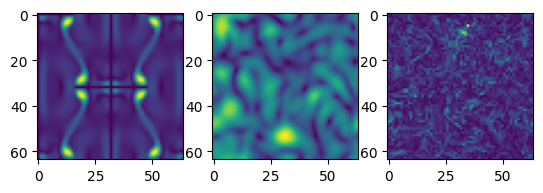

In [ ]:
plt.subplot(1,3,1)
plt.imshow(TG1800[32],cmap='viridis')
plt.subplot(1,3,2)
plt.imshow(Wf456_r20[32],cmap='viridis')
plt.subplot(1,3,3)
plt.imshow(wf456_r1800[32],cmap='viridis')

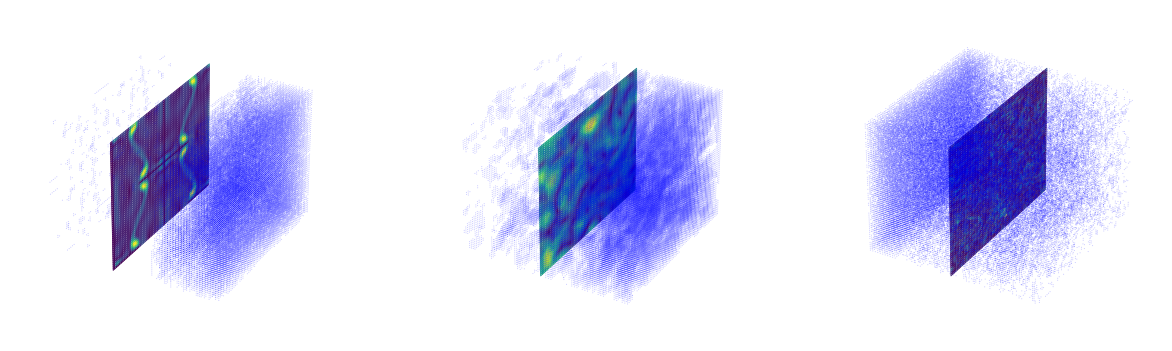

In [ ]:
fig = plt.figure(figsize=(30, 10),dpi=50)
ax1 = fig.add_subplot(1,3 , 1, projection='3d')
ax2 = fig.add_subplot(1,3 , 2, projection='3d')
ax3 = fig.add_subplot(1,3 , 3, projection='3d')

plot_3D(TG1800,ax=ax1,selected_slice=32)
plot_3D(Wf456_r20,ax=ax2,selected_slice=32)
plot_3D(wf456_r1800,ax=ax3,selected_slice=32)


### Load data - Erico

In [ ]:
!gdown 1X5aOr5kQm6NpdSLiTVWt-Fwm-ttwQfTL

Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1X5aOr5kQm6NpdSLiTVWt-Fwm-ttwQfTL

but Gdown can't. Please check connections and permissions.


In [ ]:
!unzip  "simulaturb_Erico_Rempel_ITA.zip"

Archive:  simulaturb_Erico_Rempel_ITA.zip
  inflating: ux_1.dat                
  inflating: ux_2.dat                
  inflating: ux_3.dat                
  inflating: ux_4.dat                
  inflating: ux_5.dat                
  inflating: ux_6.dat                
  inflating: ux_7.dat                
  inflating: ux_8.dat                
  inflating: ux_9.dat                
  inflating: ux_10.dat               
  inflating: ux_11.dat               
  inflating: ux_12.dat               
  inflating: ux_13.dat               
  inflating: ux_14.dat               
  inflating: ux_15.dat               
  inflating: ux_16.dat               
  inflating: ux_17.dat               
  inflating: ux_18.dat               
  inflating: ux_19.dat               
  inflating: ux_20.dat               
  inflating: ux_21.dat               
  inflating: ux_22.dat               
  inflating: ux_23.dat               
  inflating: ux_24.dat               
  inflating: ux_25.dat               
  inflat

(6, 64, 64)


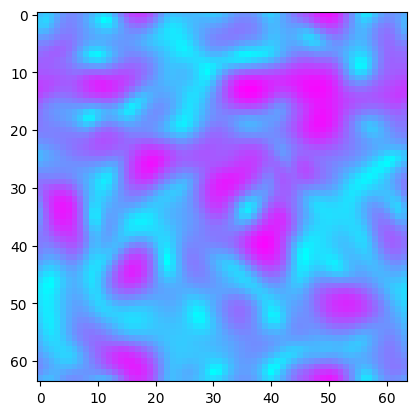

In [ ]:
def readMod(i):
  dx = pd.read_csv(f'ux_{i}.dat', header=None, delimiter='\s+',  on_bad_lines='skip').to_numpy()
  dy = pd.read_csv(f'uy_{i}.dat', header=None, delimiter='\s+',  on_bad_lines='skip').to_numpy()
  dz = pd.read_csv(f'uz_{i}.dat', header=None, delimiter='\s+',  on_bad_lines='skip').to_numpy()
  return np.sqrt(dx**2+dy**2+dz**2)
mhd_data_cube = []

#Load data
for i in range(25):
  if 'ux' in os.listdir()[i]:
    mhd_data_cube.append(readMod(i))
mhd_data_cube = np.array(mhd_data_cube)
print(mhd_data_cube.shape)
plt.figure()
plt.imshow(mhd_data_cube[1],cmap='cool')
plt.show()

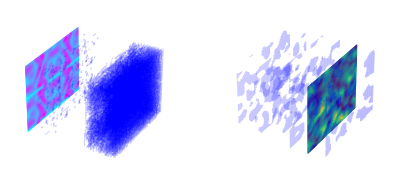

In [ ]:
fig = plt.figure(figsize=(10, 10),dpi=50)
    # Plot 3D noise cube in the first row
ax1 = fig.add_subplot(1,2 , 1, projection='3d')
plot_3D(hidro_data_cube,selected_slice=4,color_map='cool',ax=ax1)

ax2 = fig.add_subplot(1,2 , 2, projection='3d')
plot_3D(mhd_data_cube,selected_slice=4,color_map='viridis',ax=ax2)

In [ ]:
!unzip  "Slices.zip" -d "./danton_slices"

Archive:  Slices.zip
   creating: ./danton_slices/Slices/
  inflating: ./danton_slices/Slices/slice_bb1.xy  
  inflating: ./danton_slices/Slices/slice_bb1.xy2  
  inflating: ./danton_slices/Slices/slice_bb1.xz  
  inflating: ./danton_slices/Slices/slice_bb1.yz  
  inflating: ./danton_slices/Slices/slice_bb2.xy  
  inflating: ./danton_slices/Slices/slice_bb2.xy2  
  inflating: ./danton_slices/Slices/slice_bb2.xz  
  inflating: ./danton_slices/Slices/slice_bb2.yz  
  inflating: ./danton_slices/Slices/slice_bb3.xy  
  inflating: ./danton_slices/Slices/slice_bb3.xy2  
  inflating: ./danton_slices/Slices/slice_bb3.xz  
  inflating: ./danton_slices/Slices/slice_bb3.yz  
  inflating: ./danton_slices/Slices/slice_oo1.xy  
  inflating: ./danton_slices/Slices/slice_oo1.xy2  
  inflating: ./danton_slices/Slices/slice_oo1.xz  
  inflating: ./danton_slices/Slices/slice_oo1.yz  
  inflating: ./danton_slices/Slices/slice_oo2.xy  
  inflating: ./danton_slices/Slices/slice_oo2.xy2  
  inflating: ./dant

In [ ]:
!pip install git+https://github.com/pencil-code/pencil-code.git


  Cloning https://github.com/pencil-code/pencil-code.git to /tmp/pip-req-build-6qidp2xy
  Running command git clone --filter=blob:none --quiet https://github.com/pencil-code/pencil-code.git /tmp/pip-req-build-6qidp2xy
  Resolved https://github.com/pencil-code/pencil-code.git to commit 8fb4747b311c36d56a477395c14516fef17500fe
  Running command git submodule update --init --recursive -q
  fatal: No url found for submodule path 'src/astaroth/NUMA-scheduler' in .gitmodules
  error: subprocess-exited-with-error
  
  × git submodule update --init --recursive -q did not run successfully.
  │ exit code: 128
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× git submodule update --init --recursive -q did not run successfully.
│ exit code: 128
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [ ]:
import pencil as pc

# caminho da pasta com os arquivos
path = "./danton_slices/"

# leitura dos slices
slice_xy = pc.read.slice(path + "slice.bb1.xy")
slice_xy2 = pc.read.slice(path + "slice.bb1.xy2")
slice_xz = pc.read.slice(path + "slice.bb1.xz")
slice_yz = pc.read.slice(path + "slice.bb1.yz")

AttributeError: module 'pencil' has no attribute 'read'

## Pré-processing

In [ ]:
raw_data = [TG1800,
            Wf456_r20,
            wf456_r1800,
            mhd_data_cube,
            # Adicione aqui o cubo de sua prefência
            ]

dataset = []
for data in raw_data:
  dataset.append(df_entropys(data,GPA=False))

sup_title = "Hidro vs MHD"
colors = ['green','red','blue','violet']
class_names = ['TG1800','Wf456_r20','wf456_r1800', 'MHD']

100%|██████████| 6/6 [00:00<00:00, 15.50it/s]


## Results

### Tabela Latex

In [ ]:
print(gerar_tabela_latex(dataset, class_names,round_media=3, round_std=3))

\begin{table}[!ht]\label{tab:dataset}
\caption{}
  \begin{center}
    \begin{tabular}{l c c c c}
      \hline
\textbf{d} & \textbf{TG1800}  & \textbf{Wf456_r20}  & \textbf{wf456_r1800}  & \textbf{MHD} \\ \midrule
$S^h_H$ & 0.831 ± 0.072 & 0.932 ± 0.017 & 0.859 ± 0.028 & 0.941 ± 0.012\\
$S^p_H$ & 0.961 ± 0.036 & 0.896 ± 0.011 & 1.0 ± 0.0 & 0.894 ± 0.005\\
$S^s_H$ & 0.621 ± 0.092 & 0.57 ± 0.039 & 0.919 ± 0.018 & 0.561 ± 0.014\\
$S^h_q$ & -1.755 ± 0.04 & -1.799 ± 0.006 & -1.77 ± 0.012 & -1.802 ± 0.004\\
$S^p_q$ & -1.863 ± 0.025 & -1.84 ± 0.008 & -1.909 ± 0.0 & -1.837 ± 0.004\\
$S^s_q$ & -1.747 ± 0.056 & -1.725 ± 0.031 & -1.887 ± 0.006 & -1.724 ± 0.011\\
      \hline
    \end{tabular}
  \end{center}
\end{table}


### Score de Silueta

('Spectral_Shannon', 'Histogram_Shannon') with score 0.1503884067012798


<Figure size 1500x1200 with 0 Axes>

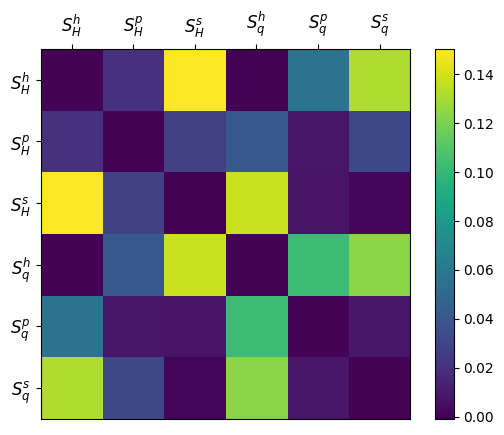

In [ ]:
plt.figure(figsize=(5,4),dpi=300)
scores = silhouette_score(dataset,prin_best_correlation=True)
plot_silhouette_score(scores,cmap="viridis")
# plt.savefig('Silhueta.pdf')
plt.show()

### Triangle Plot

<ipython-input-62-7a53bcdb5e42>:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


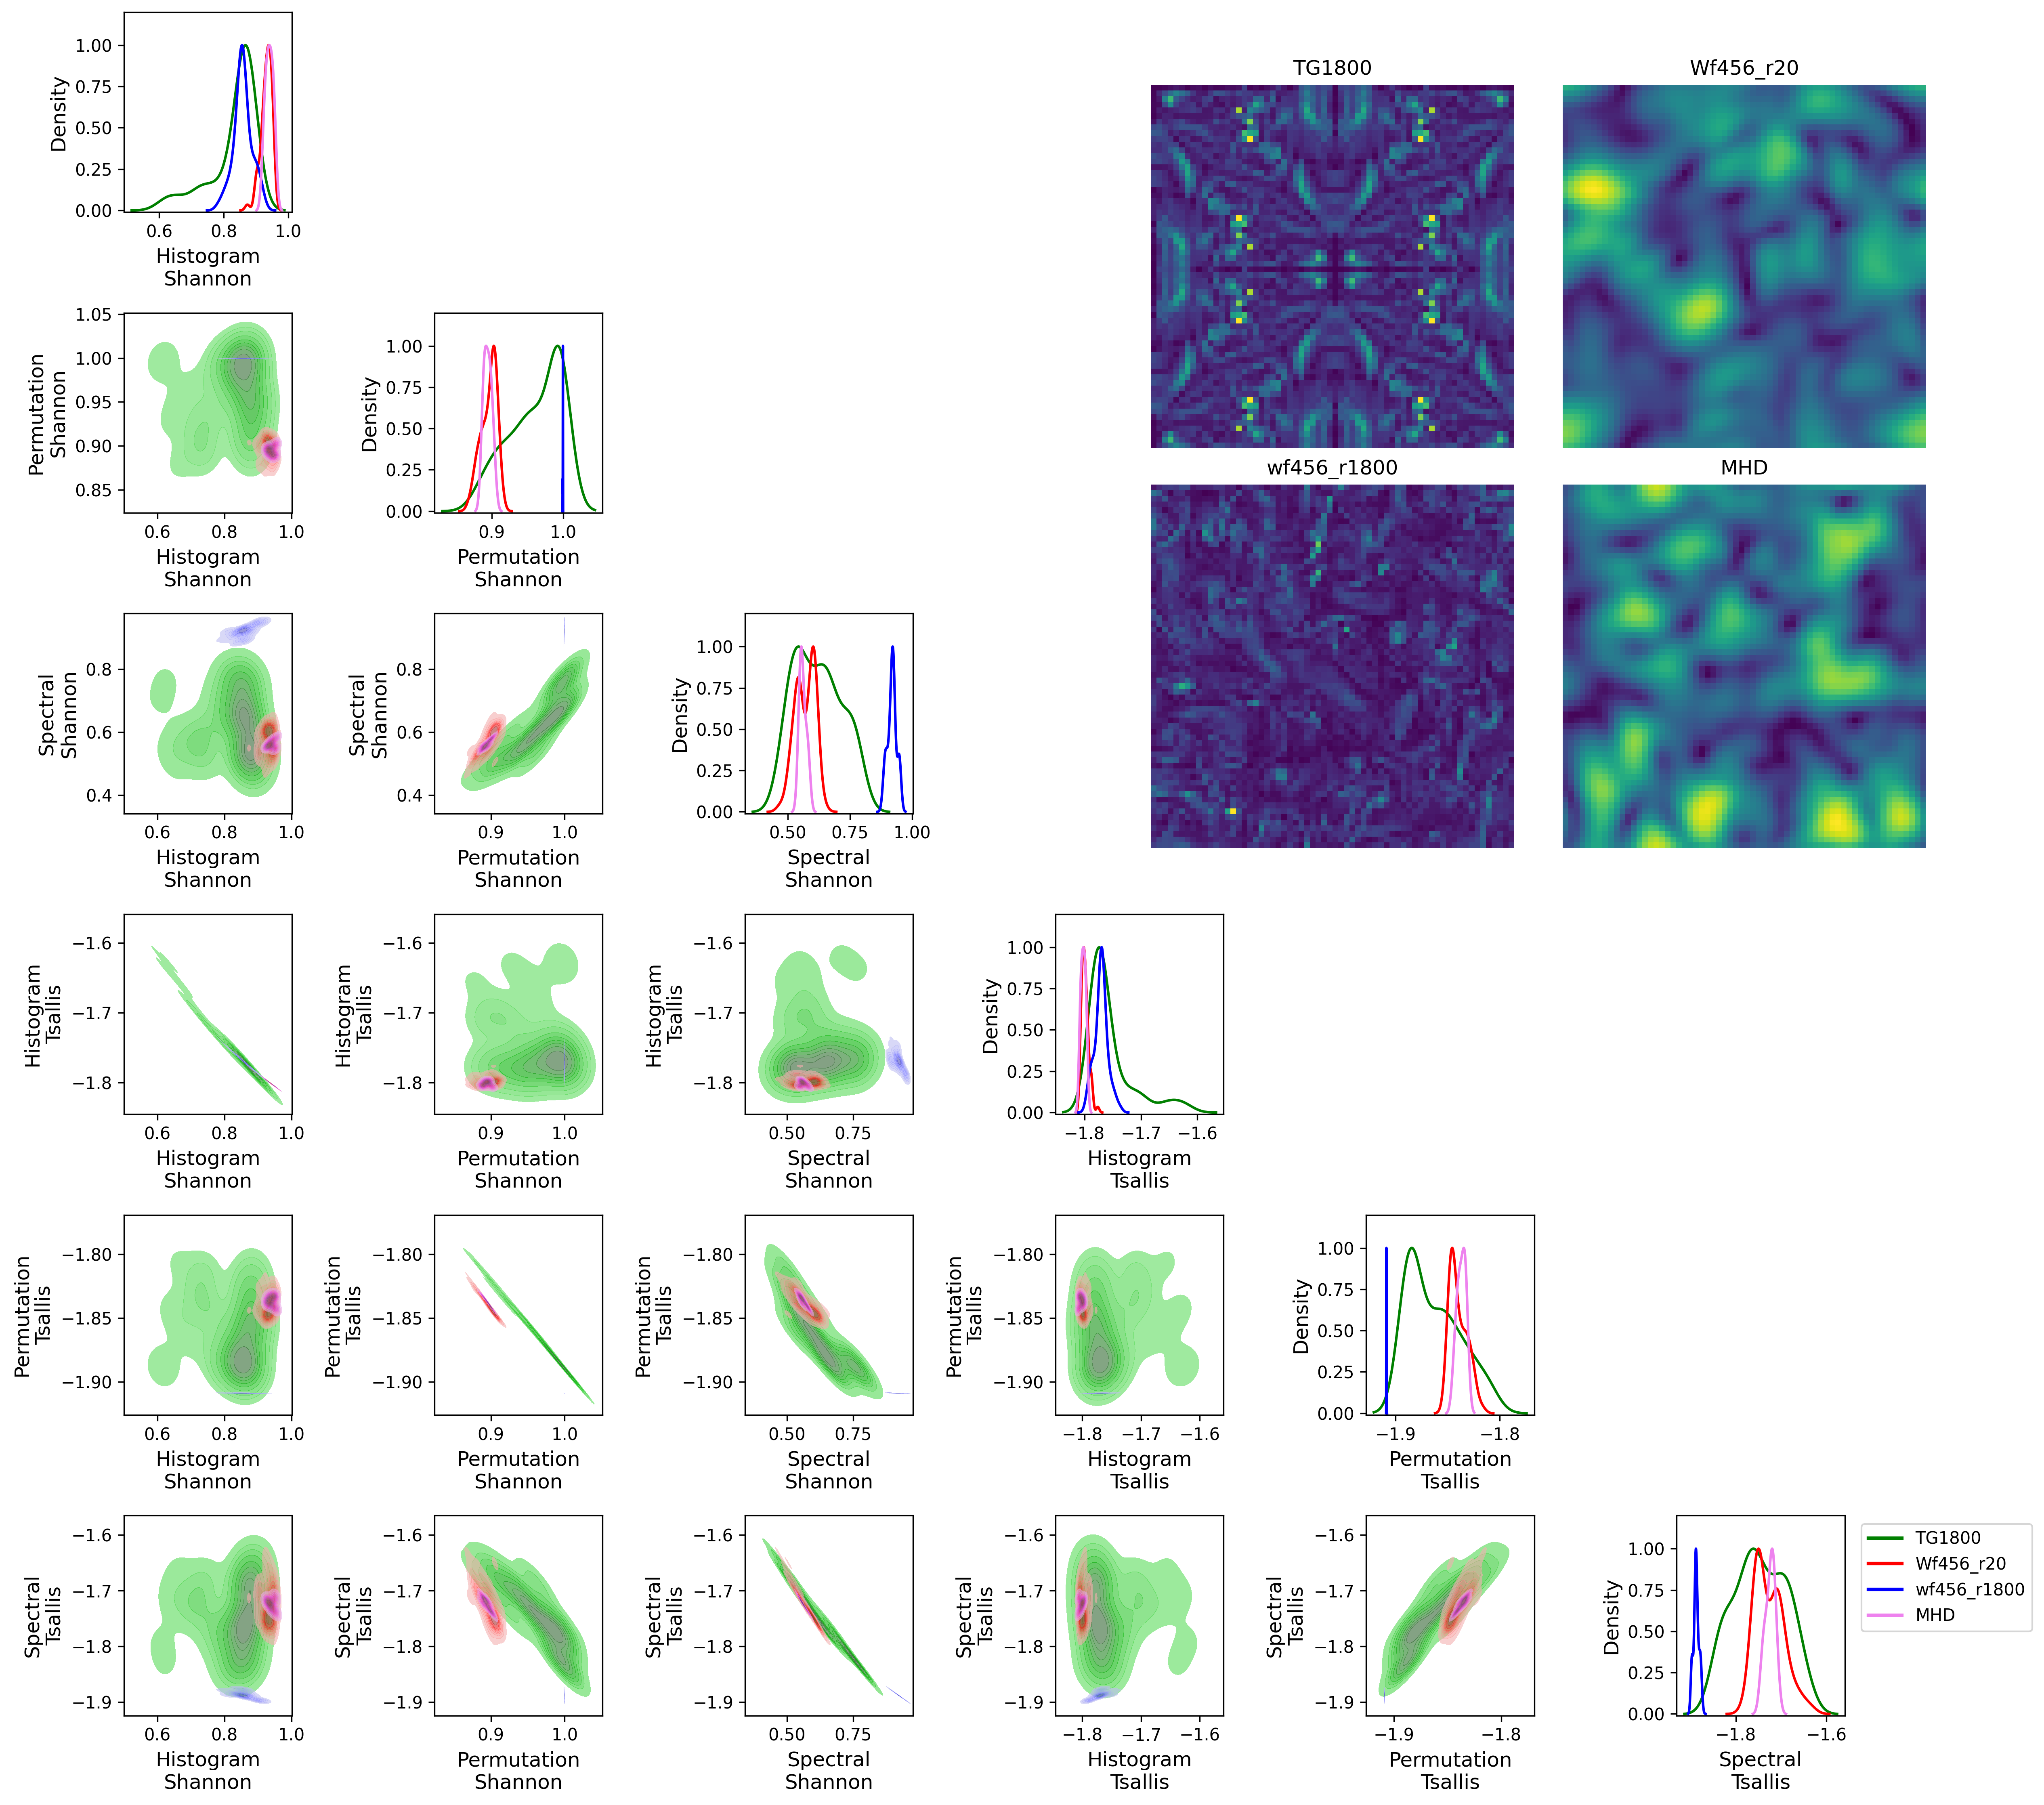

In [ ]:
fig = plt.figure(figsize=(17, 15), dpi=300)
fontsize = 12

triangle_kdeplot(dataset,colors,
                 class_names=class_names,
                 fontsize=fontsize,
                 fill =True, alpha = 0.6)

# Inserir imagens na parte inferior da figura
img_positions = [(0.55, .75), (0.75, .75), (0.55, .53),  (0.75, .53)] #posições das imagens. Setado incialmente para caber 4 figuras. Se quiser colocar mais tem que ajustar o tamanho
Width, Height = 0.2, 0.2
for k in range(len(raw_data)):
    ax_img = fig.add_axes([img_positions[k][0], img_positions[k][1], Width, Height])
    ax_img.imshow(raw_data[k][-1])
    ax_img.set_title(class_names[k], fontsize=fontsize)
    ax_img.axis('off')

plt.tight_layout()
# save_imagens_path = "/home/barauna/MEGA/Academia/DOUTORADO/Tese/figuras/"
# plt.savefig(f'{save_imagens_path}triangle_KDEioxies.png', dpi=100)
# plt.savefig(f'{save_imagens_path}triangle_KDEioxies.pdf', dpi=300)
plt.show()

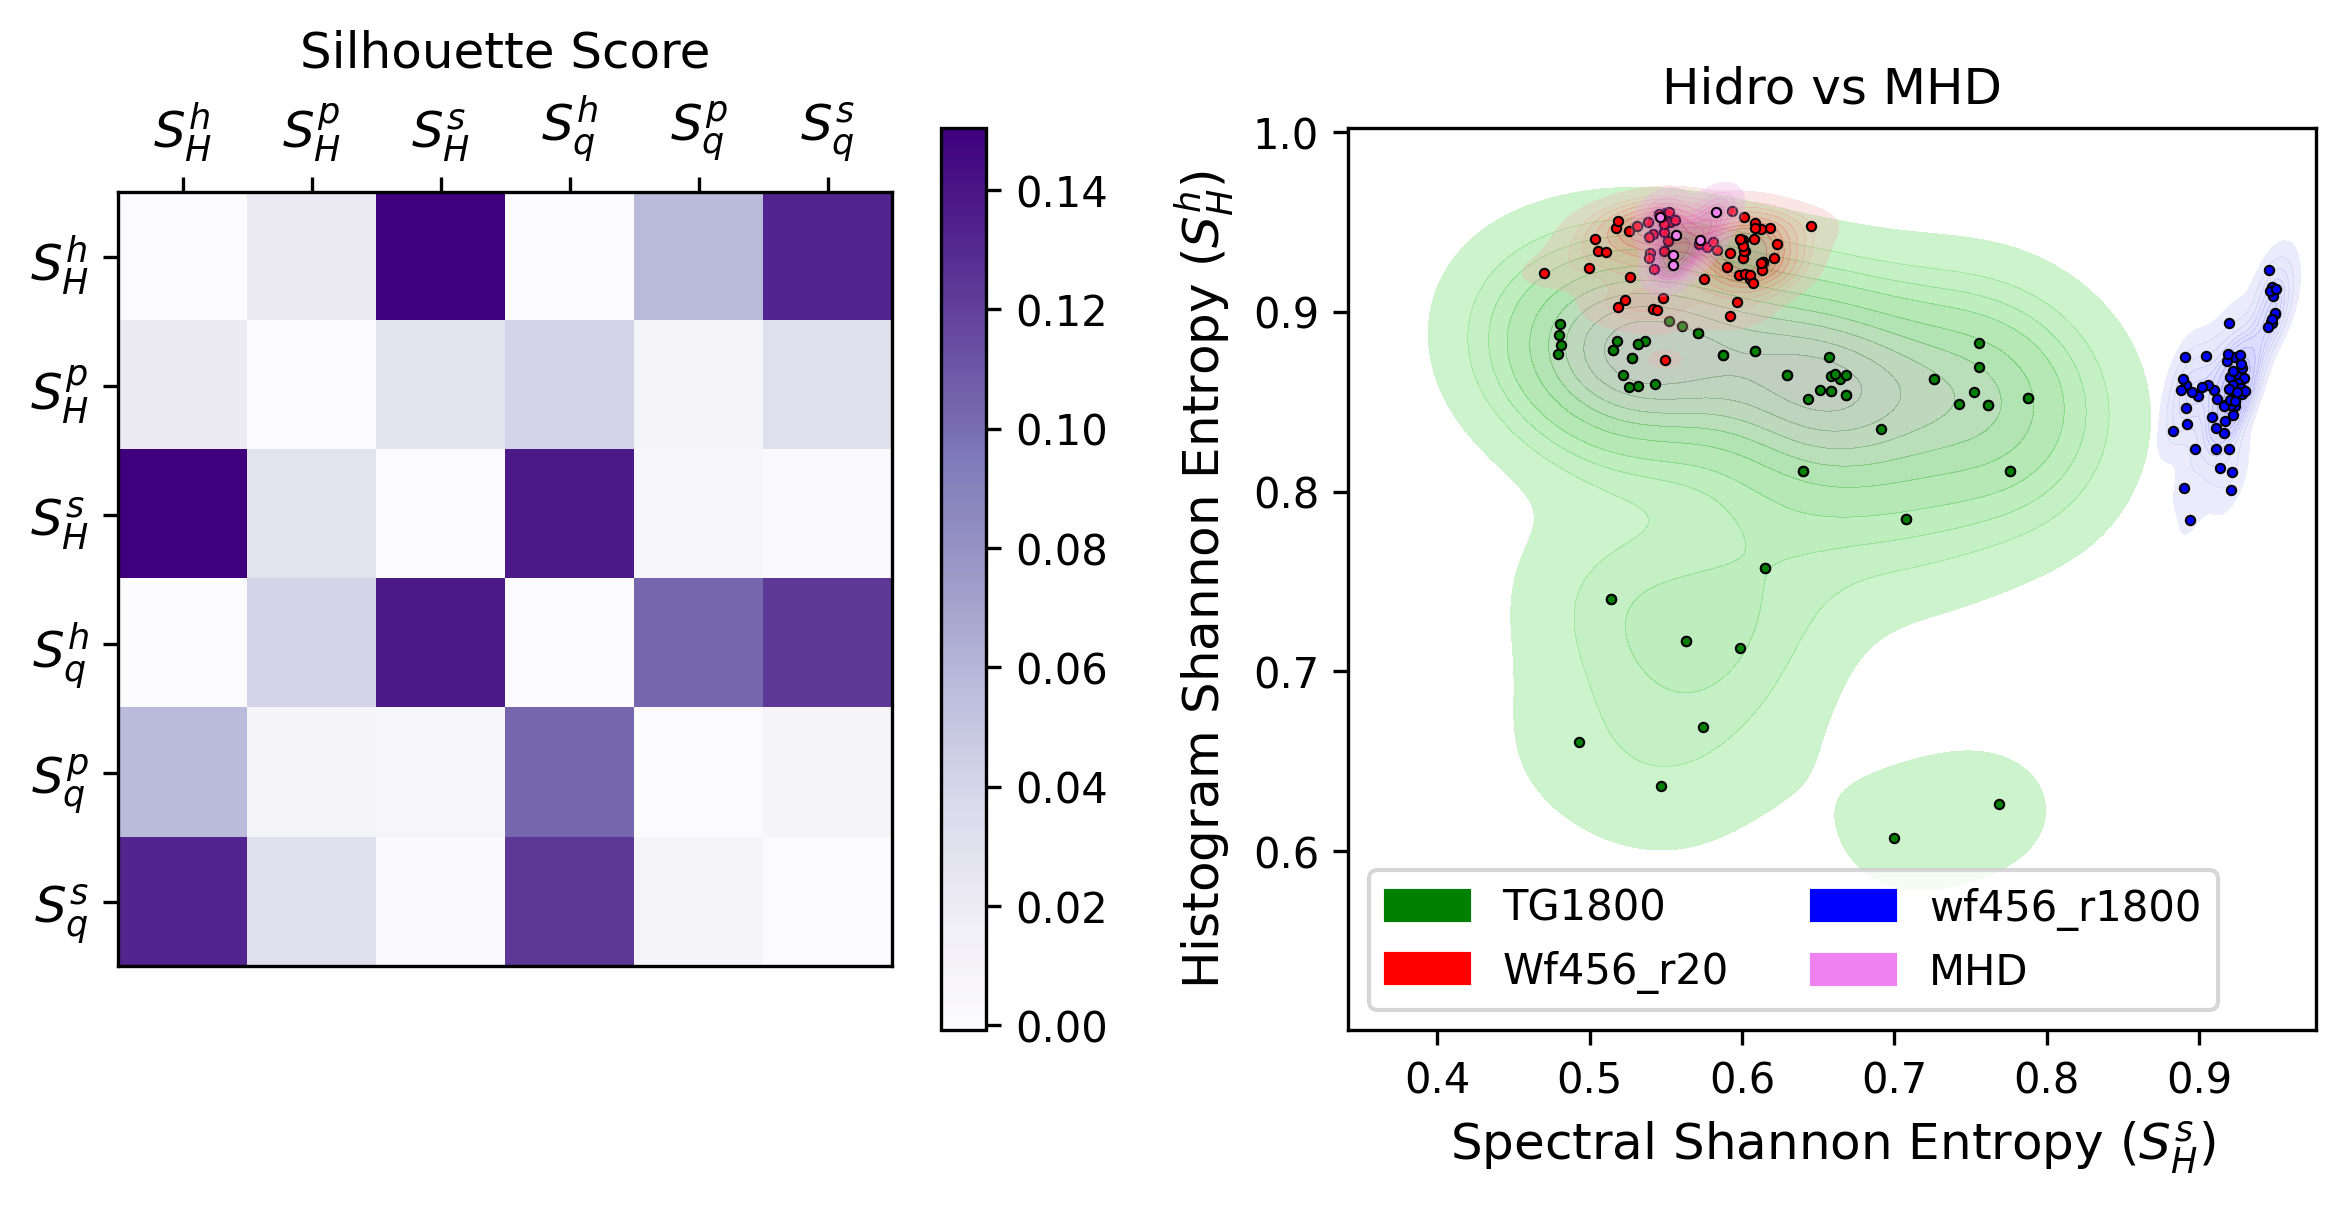

In [ ]:
plt.figure(figsize=(8, 4), dpi=300)

ax1 = plt.subplot(1, 2, 1)
plot_silhouette_score(scores, ax=ax1, cmap='Purples')
ax1.set_title("Silhouette Score")

ax2 = plt.subplot(1, 2, 2)
plot_one_pair(dataset, ax=ax2,
              colors=colors,
              class_names=class_names, fontsize=12)#, names_x=names_x, names_y=names_y)
ax2.set_title(sup_title)
plt.tight_layout()

# plt.savefig(f'{save_path}Silhueta.pdf',dpi=300)
# plt.savefig(f'{save_path}Silhueta.png',dpi=100)

plt.show()